Final Project - Money Oriented
Anggota :
1. Attariq M Kasfilla
2. Nizar Mochammad Yusuf

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from imblearn import over_sampling, under_sampling

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix


%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.20.1
pandas version :  1.2.4
seaborn version :  0.11.1


In [3]:
features = ['Department_label','OverTime_label', 'EnvironmentSatisfaction','JobInvolvement','YearsInCurrentRole','YearsAtCompany','YearsWithCurrManager','WorkLifeBalance','MonthlyIncome']

# Load Dataset

In [4]:
df_zscore = pd.read_csv('df_zscore.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
smote_1 = pd.read_csv('smote_1.csv')
smote_2 = pd.read_csv('smote_2.csv')

In [5]:
# data train
X_train, y_train = train[features], train.iloc[:,-1:]
X_smote_1, y_smote_1 = smote_1[features], smote_1.iloc[:,-1:]
X_smote_2, y_smote_2 = smote_2[features], smote_2.iloc[:,-1:]

# data test
X_test, y_test = test[features], test.iloc[:,-1:]

In [6]:
print(X_train.shape,y_train.shape)
print(X_smote_1.shape,y_smote_1.shape)
print(X_smote_2.shape,y_smote_2.shape)

(970, 9) (970, 1)
(1626, 9) (1626, 1)
(1219, 9) (1219, 1)


# Feature Importance

In [7]:
# Seleksi menggunakan - pandas pearson correlation 
Y = df_zscore[smote_1.columns]
pxs = Y.corr(method='pearson', min_periods=0.2)
pxs = pxs.abs()
pxs.sort_values(by='Attrition_label', inplace=True, ascending=False)
# pxs


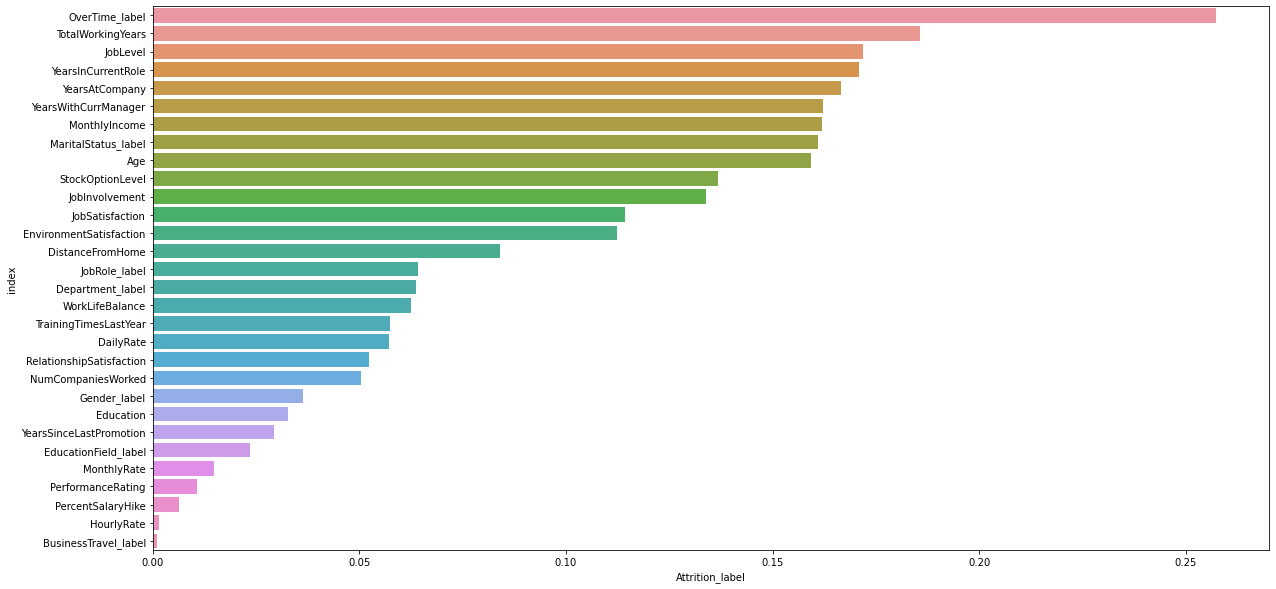

In [51]:
# nilai korelasi terhadap target 
plt.figure(figsize=(20,10))

pxs_scor_accuracy = pxs.iloc[1:,-1]
pxs_scor_accuracy
ax = sns.barplot(y='index', x='Attrition_label', data=pxs_scor_accuracy.reset_index())

# for i,bar in enumerate(ax.patches):
#     if i in [0,1,2,3,4,5,6,7,8,16]:
#         bar.set_color('#e29578')    
#     else:
#         bar.set_color('#006d77')

In [9]:
features_by_correaltion = pxs_scor_accuracy.index[:9]

In [49]:
for i in range(len(pxs_scor_accuracy)):
    if pxs_scor_accuracy.index[i] == 'WorkLifeBalance':
        print(i)

16


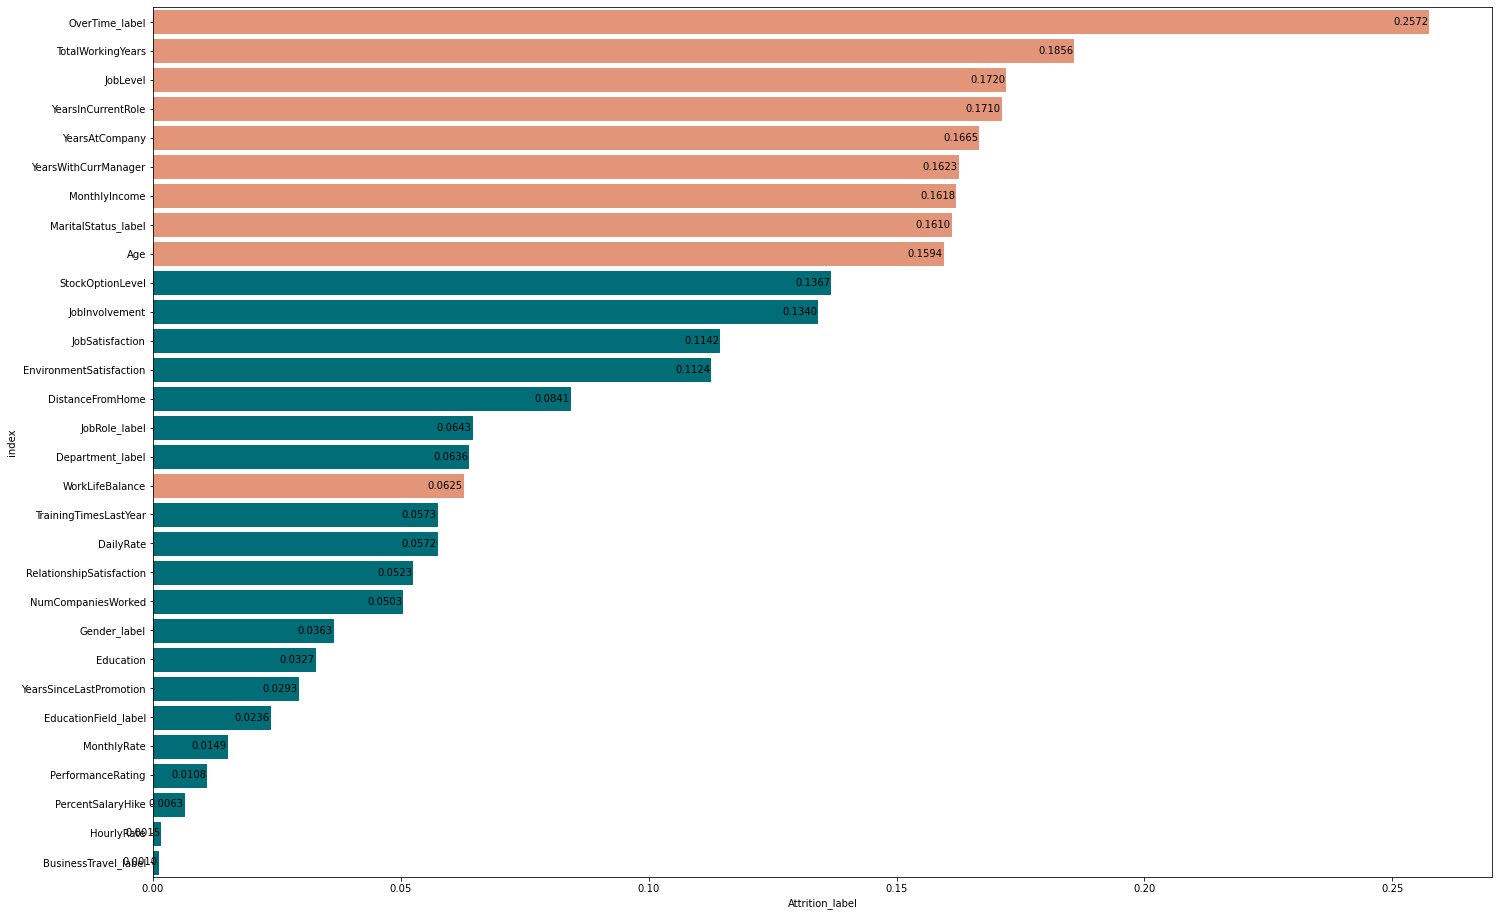

In [80]:
# nilai korelasi terhadap target 
plt.figure(figsize=(24,16))

pxs_scor_accuracy = pxs.iloc[1:,-1]
pxs_scor_accuracy
ax = sns.barplot(y='index', x='Attrition_label', data=pxs_scor_accuracy.reset_index())

for i,bar in enumerate(ax.patches):
    if i in [0,1,2,3,4,5,6,7,8,16]:
        bar.set_color('#e29578')    
    else:
        bar.set_color('#006d77')
    
    # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
    x = bar.get_width() 
    y = bar.get_y() + bar.get_height() / 2
    ax.annotate('{:.4f}'.format(x), (x, y), ha='right', va='center')

In [39]:
pxs_scor_accuracy['WorkLifeBalance']

0.06249190207447147

In [10]:
features_by_correaltion = list(features_by_correaltion)
features_by_correaltion.append('WorkLifeBalance')

In [10]:
# data train
X_train, y_train = train[features_by_correaltion], train.iloc[:,-1:]
X_smote_1, y_smote_1 = smote_1[features_by_correaltion], smote_1.iloc[:,-1:]
X_smote_2, y_smote_2 = smote_2[features_by_correaltion], smote_2.iloc[:,-1:]

# data test
X_test, y_test = test[features_by_correaltion], test.iloc[:,-1:]

# Stage 3

In [11]:
def eval_classification(model, y_pred_train, y_pred_test, xtrain, ytrain, xtest, ytest):

    # akurasi
    acc_train = round(accuracy_score(ytrain, y_pred_train), 5)
    acc_test = round(accuracy_score(ytest, y_pred_test), 5)
    # accuracy = round(accuracy_score(ytest, y_pred_test), 5)

    # precision
    precision_train = round(precision_score(ytrain, y_pred_train), 5)
    precision_test = round(precision_score(ytest, y_pred_test), 5)
    # precision = round(precision_score(ytest, y_pred_test), 5)

    # recall
    recall_train = round(recall_score(ytrain, y_pred_train), 5)
    recall_test = round(recall_score(ytest, y_pred_test), 5)
    # recall = round(recall_score(ytest, y_pred_test), 5)

    # f1
    f1_train = round(f1_score(ytrain, y_pred_train), 5)
    f1_test = round(f1_score(ytest, y_pred_test), 5)
    # f1 = round(f1_score(ytest, y_pred_test), 5)

    # print("Accuracy (Train Set): ", acc_train)
    # print("Accuracy (Test Set): ", acc_test)
    # print("Accuracy (Test Set): ", accuracy)

    # print("Accuracy (Train Set): ", precision_train)
    # print("Accuracy (Test Set): ", precision_test)
    # print("Precision (Test Set): ", precision)
    # print("Recall (Test Set): ", recall)
    # print("F1-Score (Test Set): ", f1)

    fpr, tpr, thresholds = roc_curve(ytrain, y_pred_train, pos_label=1) # pos_label: label yang kita anggap positive
    auc_score_train = round(auc(fpr, tpr), 5)
       
    fpr, tpr, thresholds = roc_curve(ytest, y_pred_test, pos_label=1) # pos_label: label yang kita anggap positive
    auc_score_test = round(auc(fpr, tpr), 5)
    # print("AUC: ", auc_score)

    # print('\nclassification report train :')
    # print(classification_report(ytrain, y_pred_train))
    # print('\nclassification report test :')
    # print(classification_report(ytest, y_pred_test))

    # plot confusion matrix
    plot_confusion_matrix(model, xtest, ytest)
    plt.title('Confussion Matrix')
    plt.show()

    return [acc_train,acc_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_score_train,auc_score_test]

# No-Tuning

## Data Train

### Modelling

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier# import knn dari sklearn
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [13]:
model = [LogisticRegression(random_state=42), KNeighborsClassifier(), DecisionTreeClassifier(random_state=42), svm.SVC(), RandomForestClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42), xgb.XGBClassifier(random_state=42)]

model_name = ['LR', 'KNN', 'DT', 'SVM', 'RF', 'GB', 'XGB']

In [14]:
score_data_train = []

MACHINE LEARNING :  LogisticRegression(random_state=42)


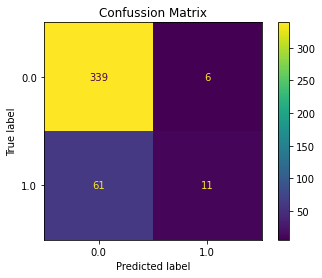

----------------------------------------------
MACHINE LEARNING :  KNeighborsClassifier()


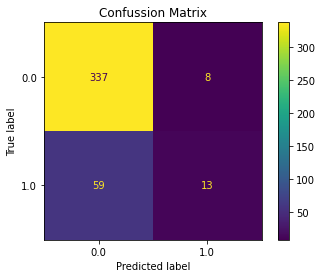

----------------------------------------------
MACHINE LEARNING :  DecisionTreeClassifier(random_state=42)


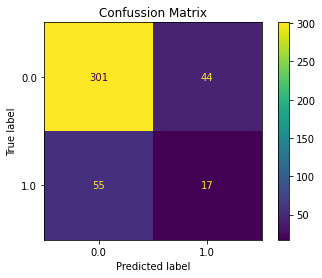

----------------------------------------------
MACHINE LEARNING :  SVC()


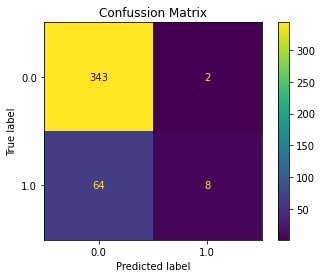

----------------------------------------------
MACHINE LEARNING :  RandomForestClassifier(random_state=42)


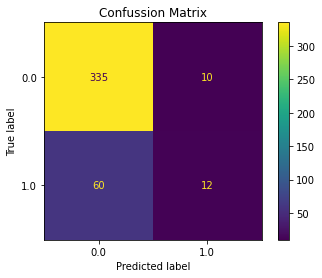

----------------------------------------------
MACHINE LEARNING :  GradientBoostingClassifier(random_state=42)


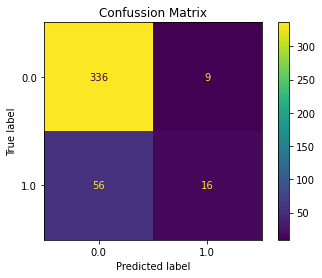

----------------------------------------------
MACHINE LEARNING :  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
[19:05:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitl

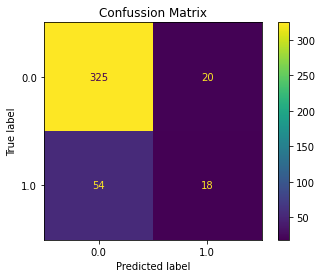

----------------------------------------------


In [15]:
for i in model:
    print('MACHINE LEARNING : ', i)
    model = i

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    score_data_train.append(eval_classification(model, y_pred_train, y_pred_test, X_train, y_train, X_test, y_test))

    print('----------------------------------------------')

### Evaluation

In [16]:
score_data_train = pd.DataFrame(score_data_train)
score_data_train.columns = ['accuracy_train', 'accuracy_test','precision_train','precision_test','recall_train','recall_test','f1_train','f1_test','auc_train','auc_test']
score_data_train.set_axis(model_name, inplace=True)

In [17]:
score_data_train

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.85876,0.83933,0.67857,0.64706,0.24204,0.15278,0.35681,0.24719,0.60995,0.56769
KNN,0.87835,0.83933,0.76712,0.61905,0.35669,0.18056,0.48696,0.27957,0.66789,0.57868
DT,1.00000,0.76259,1.00000,0.27869,1.00000,0.23611,1.00000,0.25564,1.00000,0.55429
SVM,0.85876,0.84173,0.79412,0.80000,0.17197,0.11111,0.28272,0.19512,0.58168,0.55266
RF,1.00000,0.83213,1.00000,0.54545,1.00000,0.16667,1.00000,0.25532,1.00000,0.56884
GB,0.91443,0.84412,0.90217,0.64000,0.52866,0.22222,0.66667,0.32990,0.75880,0.59807
XGB,1.00000,0.82254,1.00000,0.47368,1.00000,0.25000,1.00000,0.32727,1.00000,0.59601


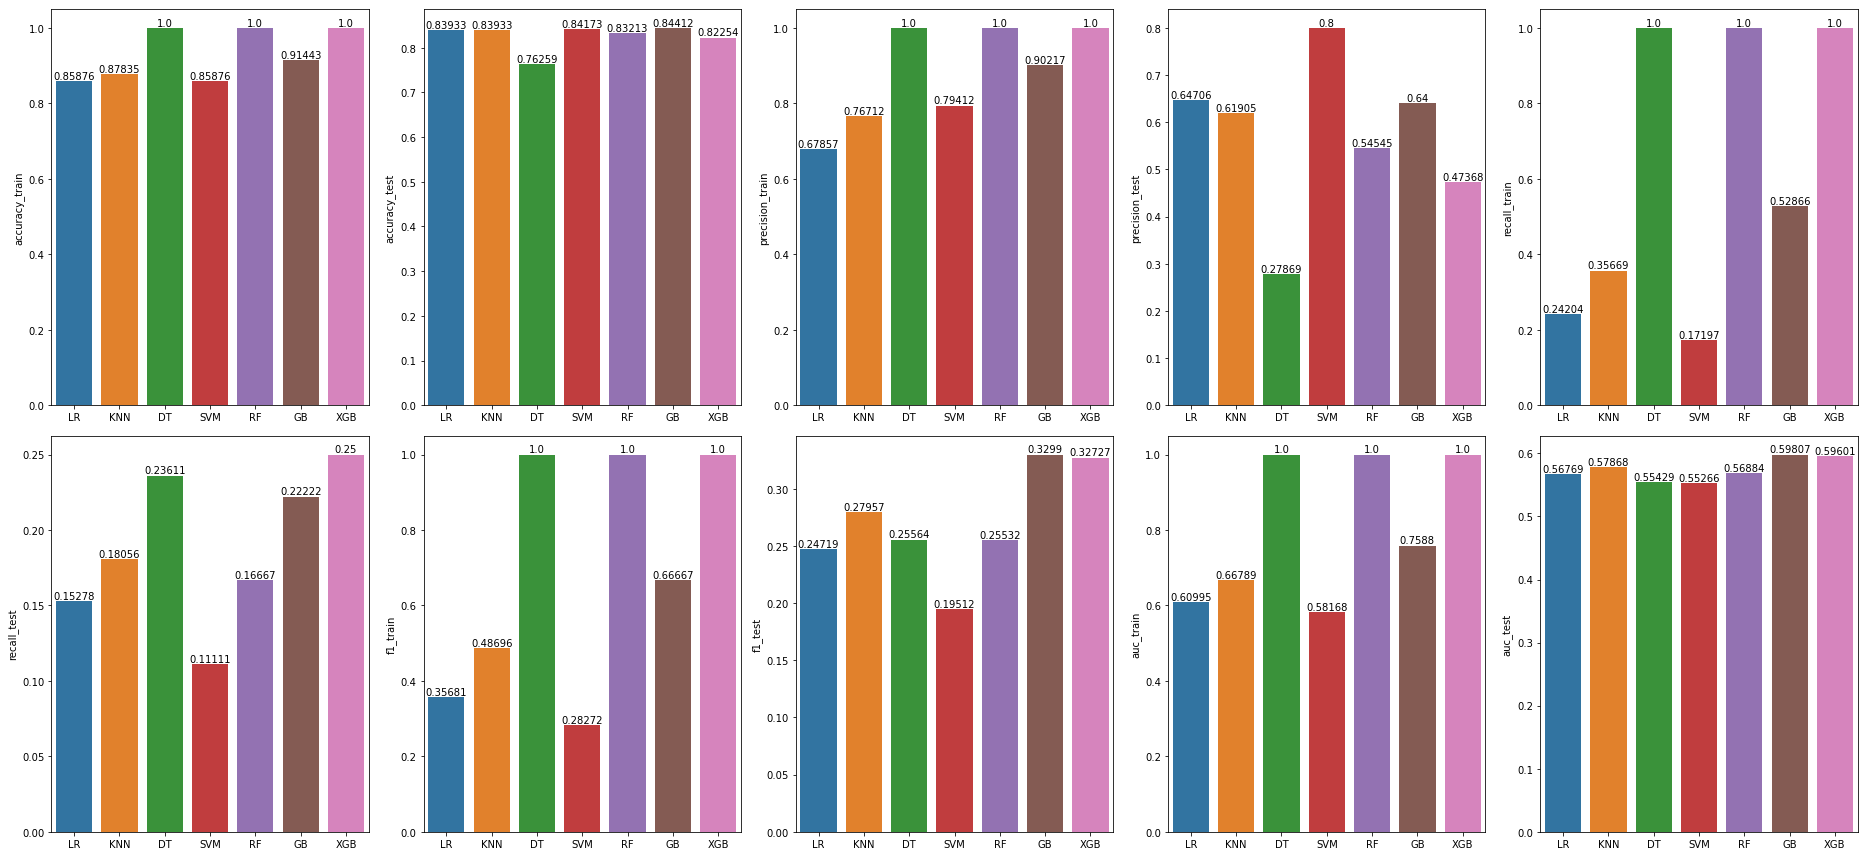

In [18]:
import math

plt.figure(figsize=(26,12))
    
for i in range(0, score_data_train.shape[1]):
    plt.subplot(2, math.ceil(score_data_train.shape[1]/2), i+1)
    ax = sns.barplot(x=score_data_train.index, y=score_data_train.columns[i], data=score_data_train)
    
    for p in ax.patches:
        # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() 
        ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

    plt.tight_layout()

## Data SMOTE 1

### Modelling

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier# import knn dari sklearn
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [20]:
model = [LogisticRegression(random_state=42), KNeighborsClassifier(), DecisionTreeClassifier(random_state=42), svm.SVC(), RandomForestClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42), xgb.XGBClassifier(random_state=42)]

model_name = ['LR', 'KNN', 'DT', 'SVM', 'RF', 'GB', 'XGB']

In [21]:
score_data_SMOTE_1 = []

MACHINE LEARNING :  LogisticRegression(random_state=42)


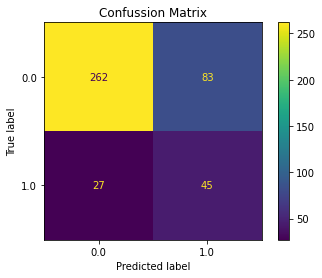

----------------------------------------------
MACHINE LEARNING :  KNeighborsClassifier()


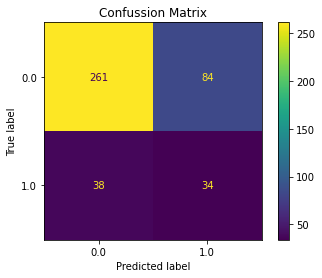

----------------------------------------------
MACHINE LEARNING :  DecisionTreeClassifier(random_state=42)


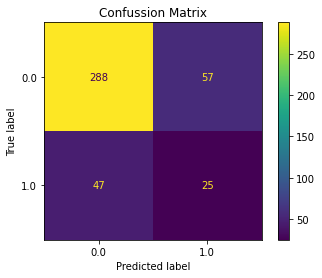

----------------------------------------------
MACHINE LEARNING :  SVC()


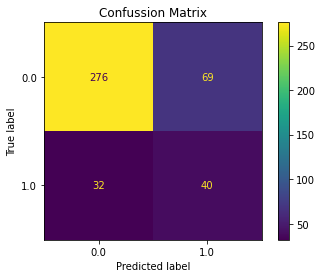

----------------------------------------------
MACHINE LEARNING :  RandomForestClassifier(random_state=42)


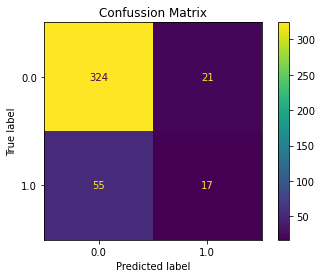

----------------------------------------------
MACHINE LEARNING :  GradientBoostingClassifier(random_state=42)


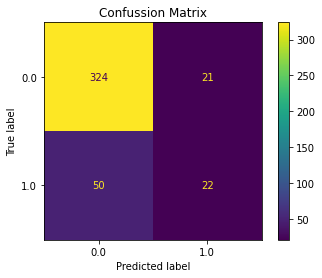

----------------------------------------------
MACHINE LEARNING :  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
[19:05:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitl

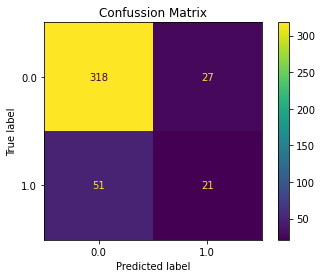

----------------------------------------------


In [22]:
for i in model:
    print('MACHINE LEARNING : ', i)
    model = i

    model.fit(X_smote_1, y_smote_1)
    y_pred_train = model.predict(X_smote_1)
    y_pred_test = model.predict(X_test)

    score_data_SMOTE_1.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_test, y_test))
    print('----------------------------------------------')

### Evaluation

In [23]:
score_data_SMOTE_1 = pd.DataFrame(score_data_SMOTE_1)
score_data_SMOTE_1.columns = ['accuracy_train', 'accuracy_test','precision_train','precision_test','recall_train','recall_test','f1_train','f1_test','auc_train','auc_test']
score_data_SMOTE_1.set_axis(model_name, inplace=True)

In [24]:
score_data_SMOTE_1

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.75646,0.73621,0.75151,0.35156,0.76630,0.62500,0.75883,0.45000,0.75646,0.69221
KNN,0.89176,0.70743,0.84064,0.28814,0.96679,0.47222,0.89931,0.35789,0.89176,0.61437
DT,1.00000,0.75060,1.00000,0.30488,1.00000,0.34722,1.00000,0.32468,1.00000,0.59100
SVM,0.83825,0.75779,0.82277,0.36697,0.86224,0.55556,0.84204,0.44199,0.83825,0.67778
RF,1.00000,0.81775,1.00000,0.44737,1.00000,0.23611,1.00000,0.30909,1.00000,0.58762
GB,0.93419,0.82974,0.95844,0.51163,0.90775,0.30556,0.93241,0.38261,0.93419,0.62234
XGB,1.00000,0.81295,1.00000,0.43750,1.00000,0.29167,1.00000,0.35000,1.00000,0.60670


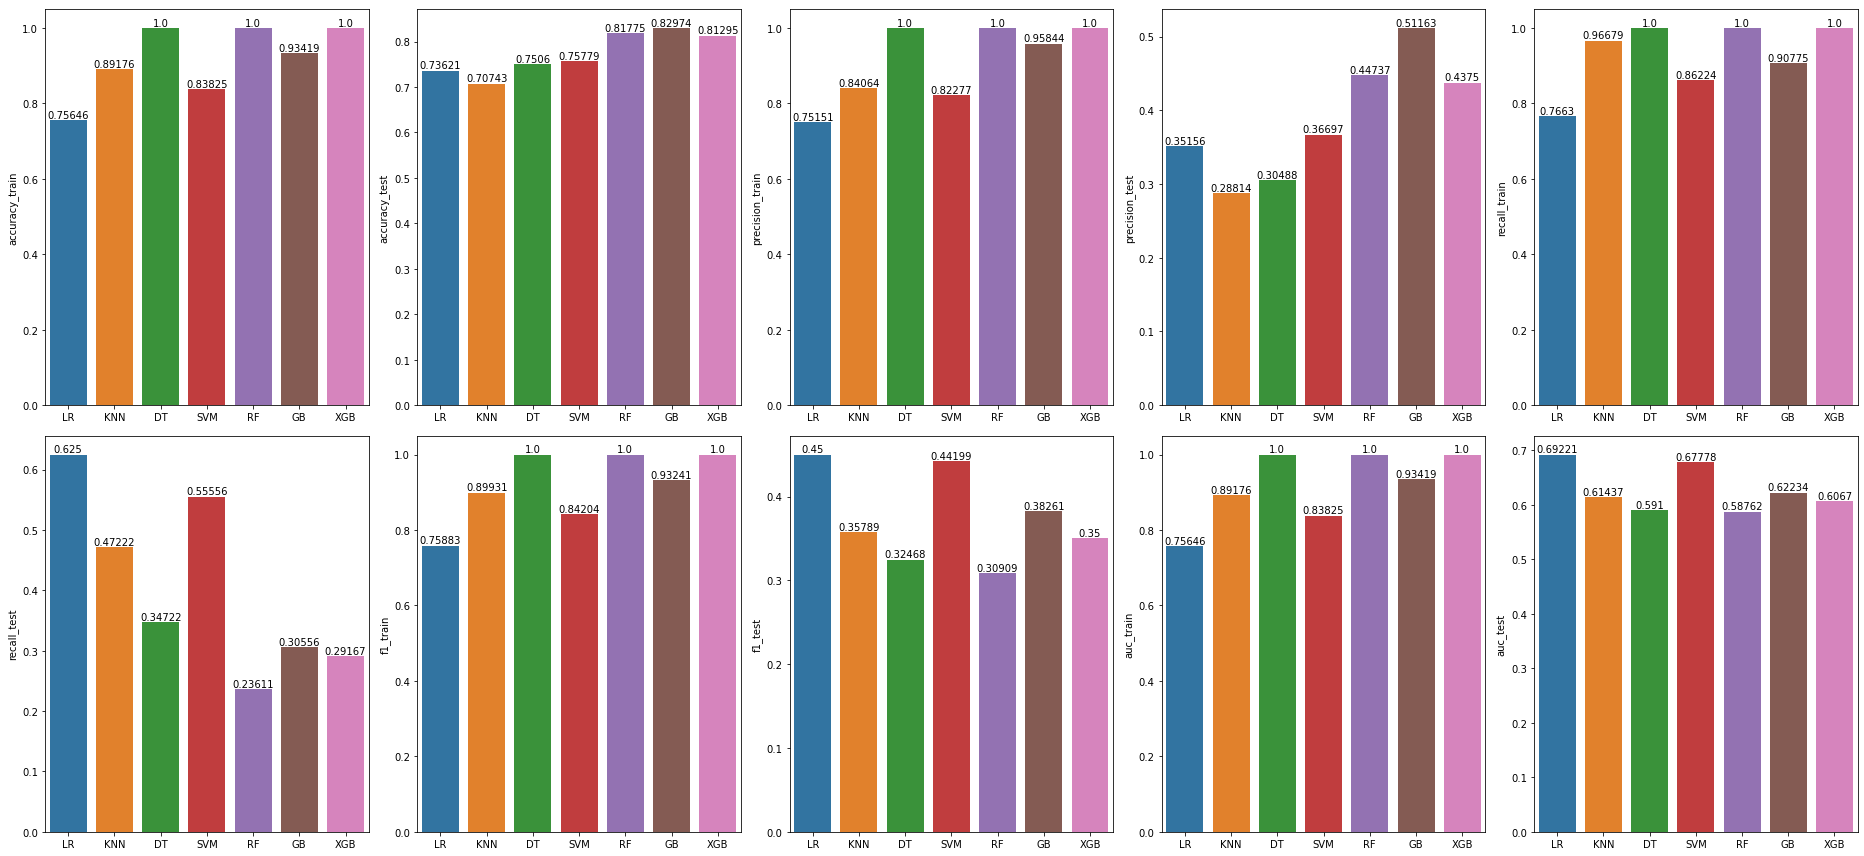

In [25]:
import math

plt.figure(figsize=(26,12))
    
for i in range(0, score_data_SMOTE_1.shape[1]):
    plt.subplot(2, math.ceil(score_data_SMOTE_1.shape[1]/2), i+1)
    ax = sns.barplot(x=score_data_SMOTE_1.index, y=score_data_SMOTE_1.columns[i], data=score_data_SMOTE_1)
    
    for p in ax.patches:
        # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() 
        ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

    plt.tight_layout()

## Data SMOTE 2

### Modelling

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier# import knn dari sklearn
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [27]:
model = [LogisticRegression(random_state=42), KNeighborsClassifier(), DecisionTreeClassifier(random_state=42), svm.SVC(), RandomForestClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42), xgb.XGBClassifier(random_state=42)]

model_name = ['LR', 'KNN', 'DT', 'SVM', 'RF', 'GB', 'XGB']

In [28]:
score_data_SMOTE_2 = []

MACHINE LEARNING :  LogisticRegression(random_state=42)


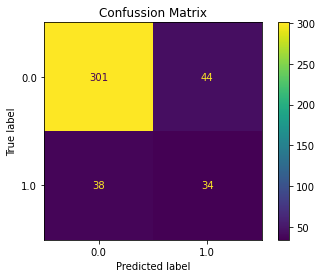

----------------------------------------------
MACHINE LEARNING :  KNeighborsClassifier()


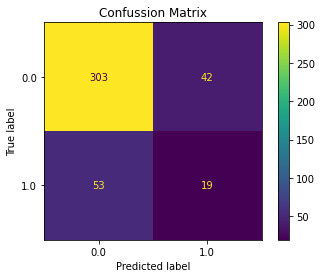

----------------------------------------------
MACHINE LEARNING :  DecisionTreeClassifier(random_state=42)


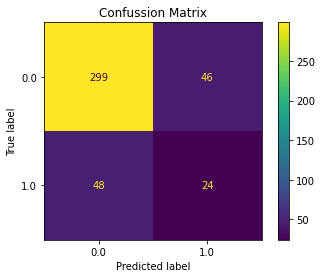

----------------------------------------------
MACHINE LEARNING :  SVC()


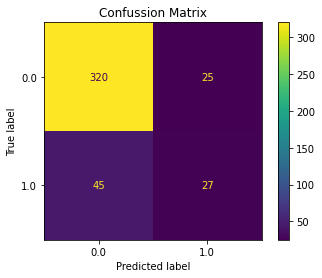

----------------------------------------------
MACHINE LEARNING :  RandomForestClassifier(random_state=42)


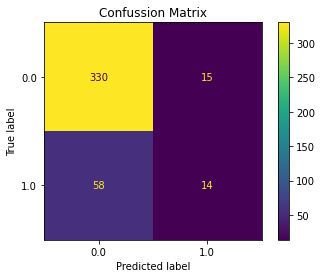

----------------------------------------------
MACHINE LEARNING :  GradientBoostingClassifier(random_state=42)


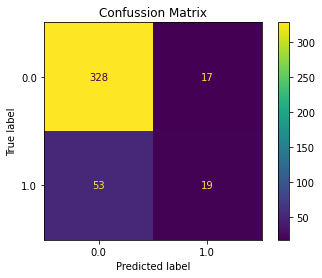

----------------------------------------------
MACHINE LEARNING :  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
[19:05:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitl

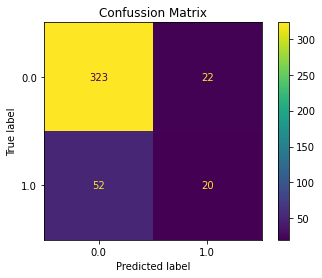

----------------------------------------------


In [29]:
for i in model:
    print('MACHINE LEARNING : ', i)
    model = i

    model.fit(X_smote_2, y_smote_2)
    y_pred_train = model.predict(X_smote_2)
    y_pred_test = model.predict(X_test)

    score_data_SMOTE_2.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_2, y_smote_2, X_test, y_test))
    print('----------------------------------------------')

### Evaluation

In [30]:
score_data_SMOTE_2 = pd.DataFrame(score_data_SMOTE_2)
score_data_SMOTE_2.columns = ['accuracy_train', 'accuracy_test','precision_train','precision_test','recall_train','recall_test','f1_train','f1_test','auc_train','auc_test']
score_data_SMOTE_2.set_axis(model_name, inplace=True)

In [31]:
score_data_SMOTE_2

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.77030,0.80336,0.69688,0.43590,0.54926,0.47222,0.61433,0.45333,0.71497,0.67234
KNN,0.88843,0.77218,0.83750,0.31148,0.82512,0.26389,0.83127,0.28571,0.87259,0.57107
DT,1.00000,0.77458,1.00000,0.34286,1.00000,0.33333,1.00000,0.33803,1.00000,0.60000
SVM,0.80968,0.83213,0.80851,0.51923,0.56158,0.37500,0.66279,0.43548,0.74758,0.65127
RF,1.00000,0.82494,1.00000,0.48276,1.00000,0.19444,1.00000,0.27723,1.00000,0.57548
GB,0.91550,0.83213,0.93410,0.52778,0.80296,0.26389,0.86358,0.35185,0.88733,0.60731
XGB,1.00000,0.82254,1.00000,0.47619,1.00000,0.27778,1.00000,0.35088,1.00000,0.60700


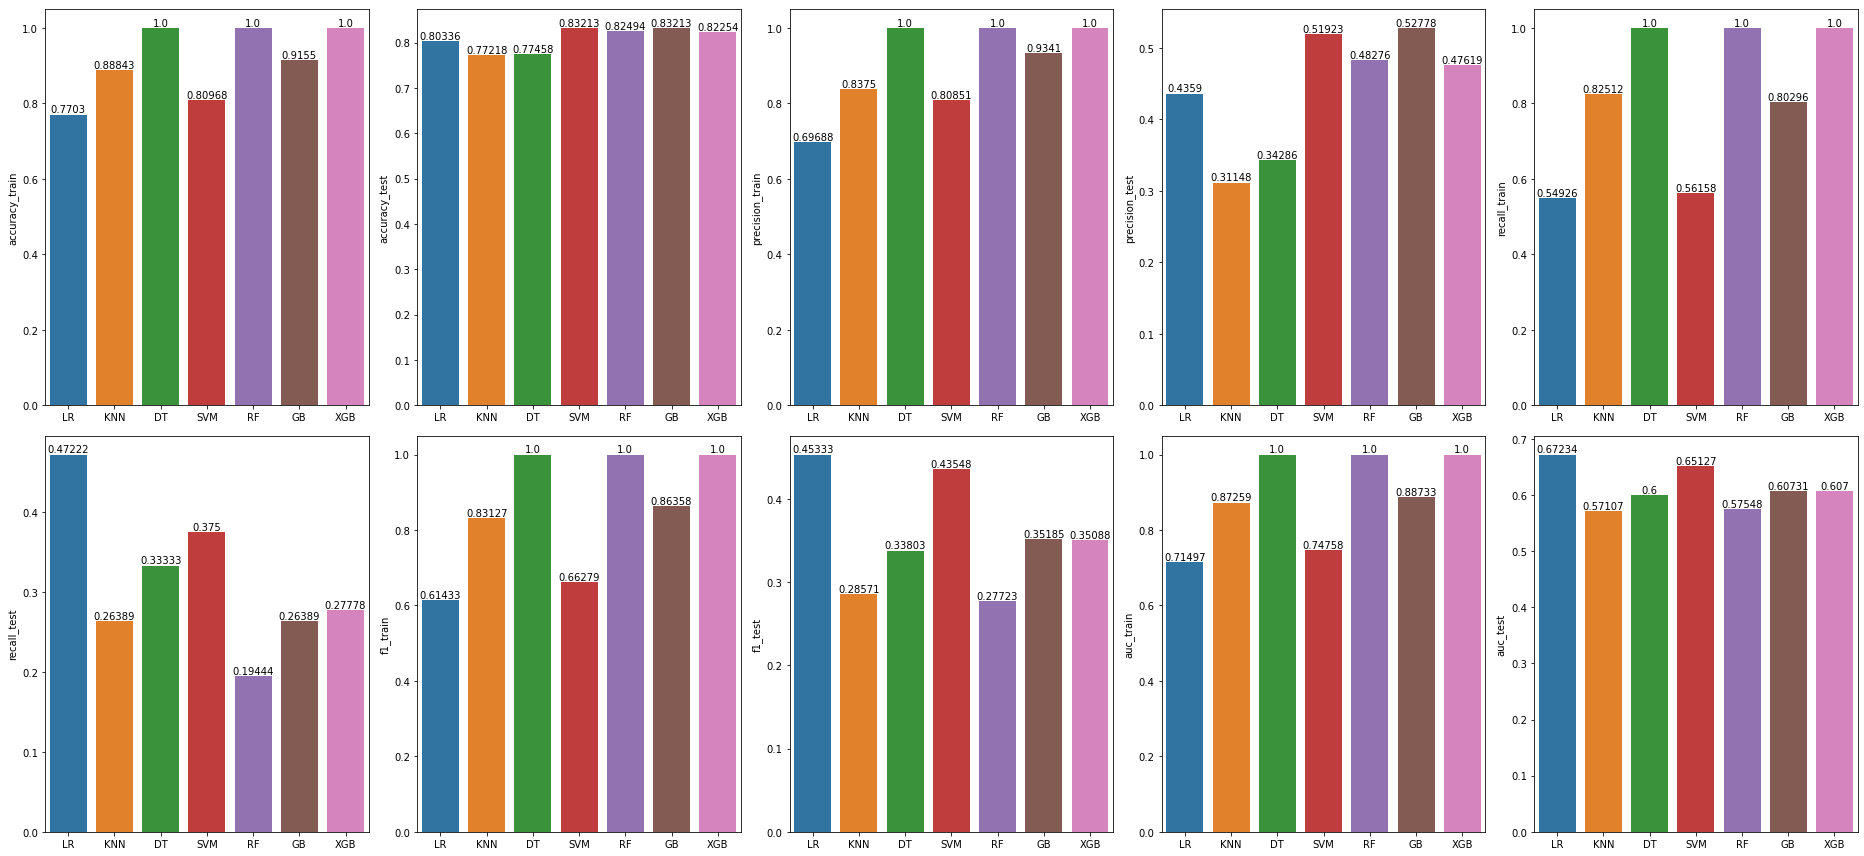

In [32]:
import math

plt.figure(figsize=(26,12))
    
for i in range(0, score_data_SMOTE_2.shape[1]):
    plt.subplot(2, math.ceil(score_data_SMOTE_2.shape[1]/2), i+1)
    ax = sns.barplot(x=score_data_SMOTE_2.index, y=score_data_SMOTE_2.columns[i], data=score_data_SMOTE_2)
    
    for p in ax.patches:
        # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() 
        ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

    plt.tight_layout()

# Top 3 - By recall test

## Top 3 - Train

In [33]:
score_data_train

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.85876,0.83933,0.67857,0.64706,0.24204,0.15278,0.35681,0.24719,0.60995,0.56769
KNN,0.87835,0.83933,0.76712,0.61905,0.35669,0.18056,0.48696,0.27957,0.66789,0.57868
DT,1.00000,0.76259,1.00000,0.27869,1.00000,0.23611,1.00000,0.25564,1.00000,0.55429
SVM,0.85876,0.84173,0.79412,0.80000,0.17197,0.11111,0.28272,0.19512,0.58168,0.55266
RF,1.00000,0.83213,1.00000,0.54545,1.00000,0.16667,1.00000,0.25532,1.00000,0.56884
GB,0.91443,0.84412,0.90217,0.64000,0.52866,0.22222,0.66667,0.32990,0.75880,0.59807
XGB,1.00000,0.82254,1.00000,0.47368,1.00000,0.25000,1.00000,0.32727,1.00000,0.59601


In [34]:
top3_train = score_data_train.sort_values(by=['recall_test'], ascending=False)[:3]
top3_train

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
XGB,1.00000,0.82254,1.00000,0.47368,1.00000,0.25000,1.00000,0.32727,1.0000,0.59601
DT,1.00000,0.76259,1.00000,0.27869,1.00000,0.23611,1.00000,0.25564,1.0000,0.55429
GB,0.91443,0.84412,0.90217,0.64000,0.52866,0.22222,0.66667,0.32990,0.7588,0.59807


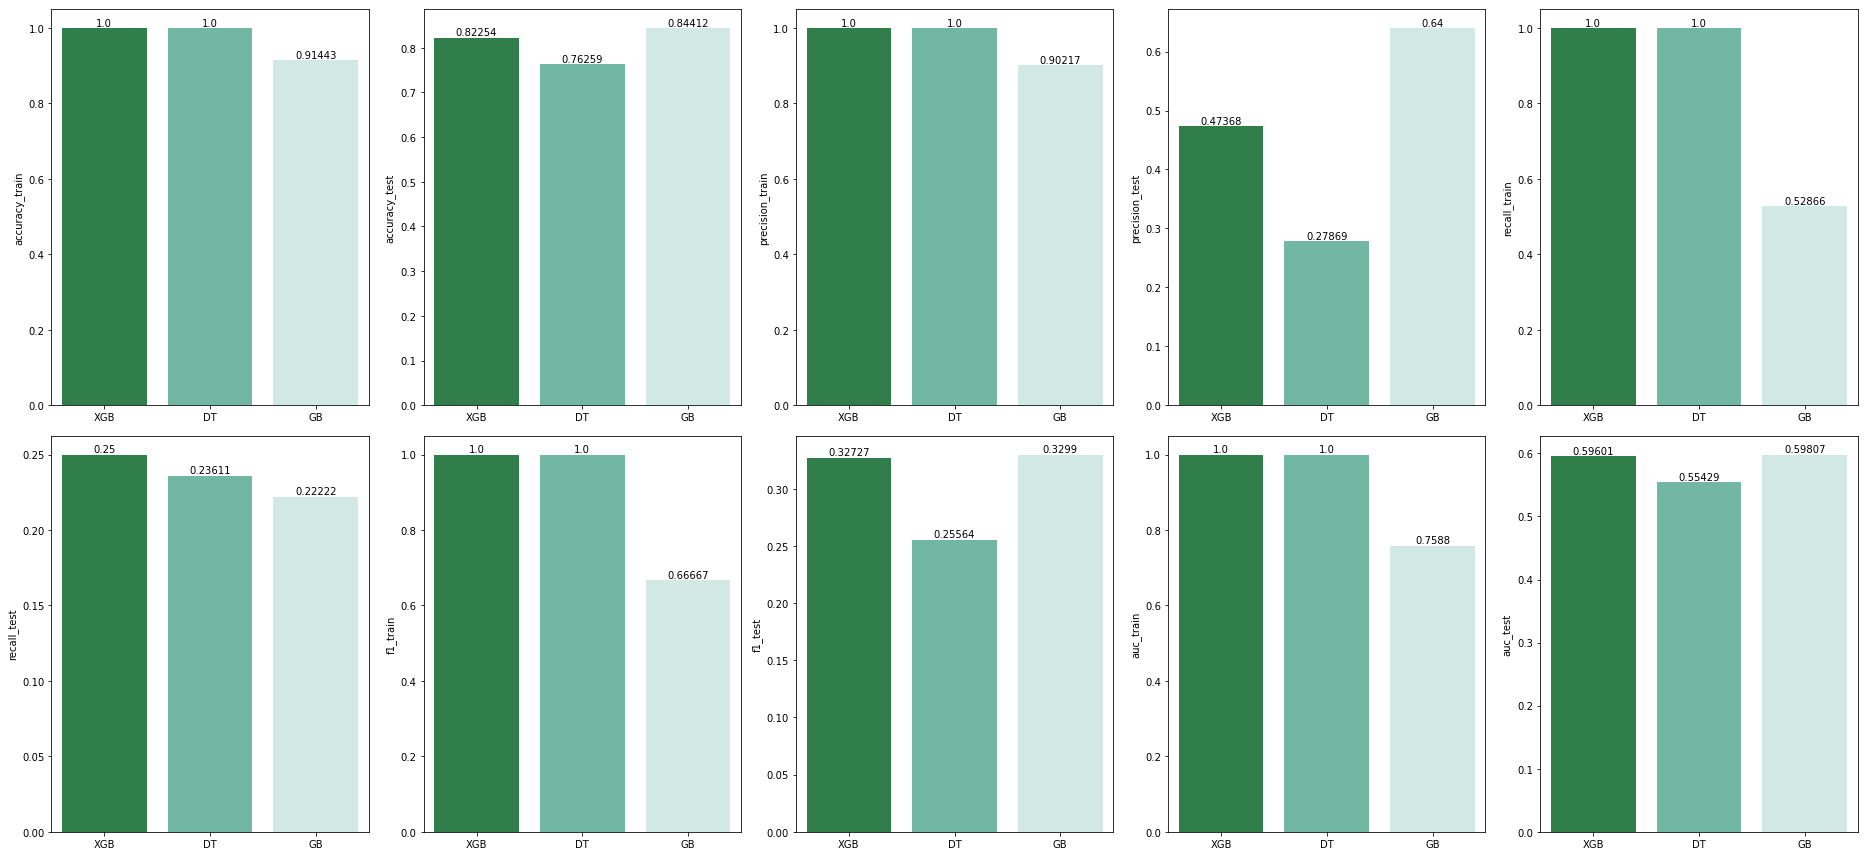

In [35]:
import math

plt.figure(figsize=(26,12))
    
for i in range(0, top3_train.shape[1]):
    plt.subplot(2, math.ceil(top3_train.shape[1]/2), i+1)
    ax = sns.barplot(x=top3_train.index, y=top3_train.columns[i], data=top3_train, palette='BuGn_r')
    
    for p in ax.patches:
        # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() 
        ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

    plt.tight_layout()

## Top 3 - SMOTE 1

In [36]:
score_data_SMOTE_1

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.75646,0.73621,0.75151,0.35156,0.76630,0.62500,0.75883,0.45000,0.75646,0.69221
KNN,0.89176,0.70743,0.84064,0.28814,0.96679,0.47222,0.89931,0.35789,0.89176,0.61437
DT,1.00000,0.75060,1.00000,0.30488,1.00000,0.34722,1.00000,0.32468,1.00000,0.59100
SVM,0.83825,0.75779,0.82277,0.36697,0.86224,0.55556,0.84204,0.44199,0.83825,0.67778
RF,1.00000,0.81775,1.00000,0.44737,1.00000,0.23611,1.00000,0.30909,1.00000,0.58762
GB,0.93419,0.82974,0.95844,0.51163,0.90775,0.30556,0.93241,0.38261,0.93419,0.62234
XGB,1.00000,0.81295,1.00000,0.43750,1.00000,0.29167,1.00000,0.35000,1.00000,0.60670


In [37]:
top3_SMOTE1 = score_data_SMOTE_1.sort_values(by=['recall_test'], ascending=False)[:3]
top3_SMOTE1

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.75646,0.73621,0.75151,0.35156,0.76630,0.62500,0.75883,0.45000,0.75646,0.69221
SVM,0.83825,0.75779,0.82277,0.36697,0.86224,0.55556,0.84204,0.44199,0.83825,0.67778
KNN,0.89176,0.70743,0.84064,0.28814,0.96679,0.47222,0.89931,0.35789,0.89176,0.61437


In [38]:
# top3_SMOTE1.iloc[:,[1,3,5,7,9]]

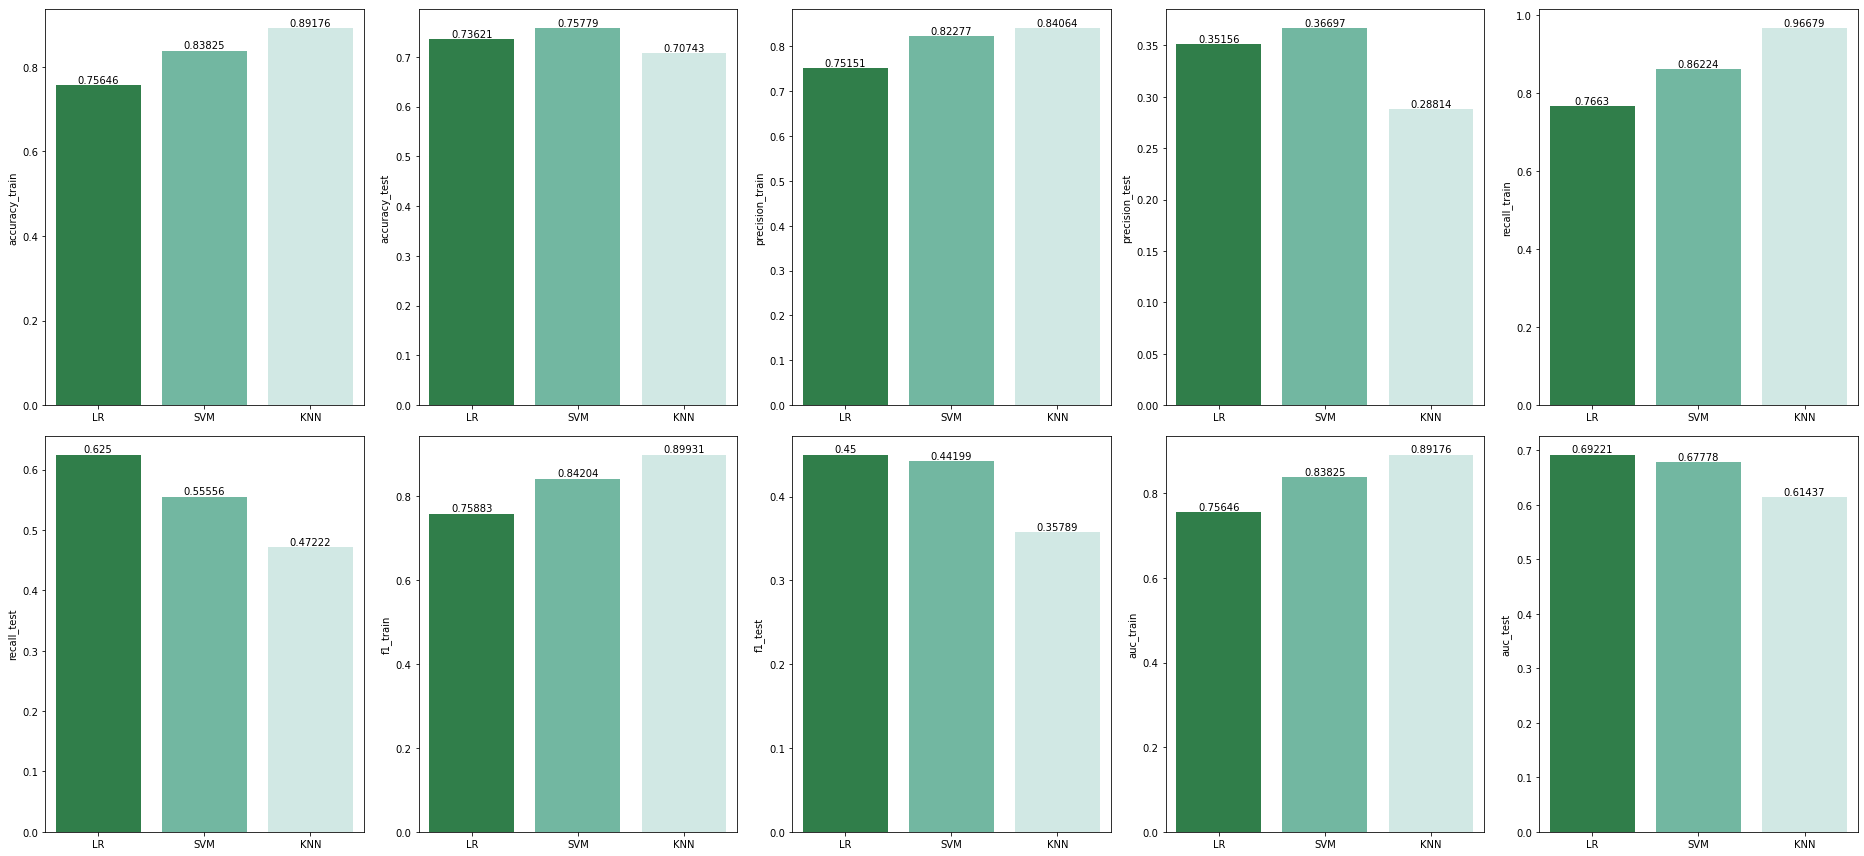

In [39]:
import math

plt.figure(figsize=(26,12))
    
for i in range(0, top3_SMOTE1.shape[1]):
    plt.subplot(2, math.ceil(top3_SMOTE1.shape[1]/2), i+1)
    ax = sns.barplot(x=top3_SMOTE1.index, y=top3_SMOTE1.columns[i], data=top3_SMOTE1, palette='BuGn_r')
    
    for p in ax.patches:
        # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() 
        ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

    plt.tight_layout()

## Top 3 - SMOTE 2

In [40]:
score_data_SMOTE_2

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.77030,0.80336,0.69688,0.43590,0.54926,0.47222,0.61433,0.45333,0.71497,0.67234
KNN,0.88843,0.77218,0.83750,0.31148,0.82512,0.26389,0.83127,0.28571,0.87259,0.57107
DT,1.00000,0.77458,1.00000,0.34286,1.00000,0.33333,1.00000,0.33803,1.00000,0.60000
SVM,0.80968,0.83213,0.80851,0.51923,0.56158,0.37500,0.66279,0.43548,0.74758,0.65127
RF,1.00000,0.82494,1.00000,0.48276,1.00000,0.19444,1.00000,0.27723,1.00000,0.57548
GB,0.91550,0.83213,0.93410,0.52778,0.80296,0.26389,0.86358,0.35185,0.88733,0.60731
XGB,1.00000,0.82254,1.00000,0.47619,1.00000,0.27778,1.00000,0.35088,1.00000,0.60700


In [41]:
top3_SMOTE2 = score_data_SMOTE_2.sort_values(by=['recall_test'], ascending=False)[:3]
top3_SMOTE2

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.77030,0.80336,0.69688,0.43590,0.54926,0.47222,0.61433,0.45333,0.71497,0.67234
SVM,0.80968,0.83213,0.80851,0.51923,0.56158,0.37500,0.66279,0.43548,0.74758,0.65127
DT,1.00000,0.77458,1.00000,0.34286,1.00000,0.33333,1.00000,0.33803,1.00000,0.60000


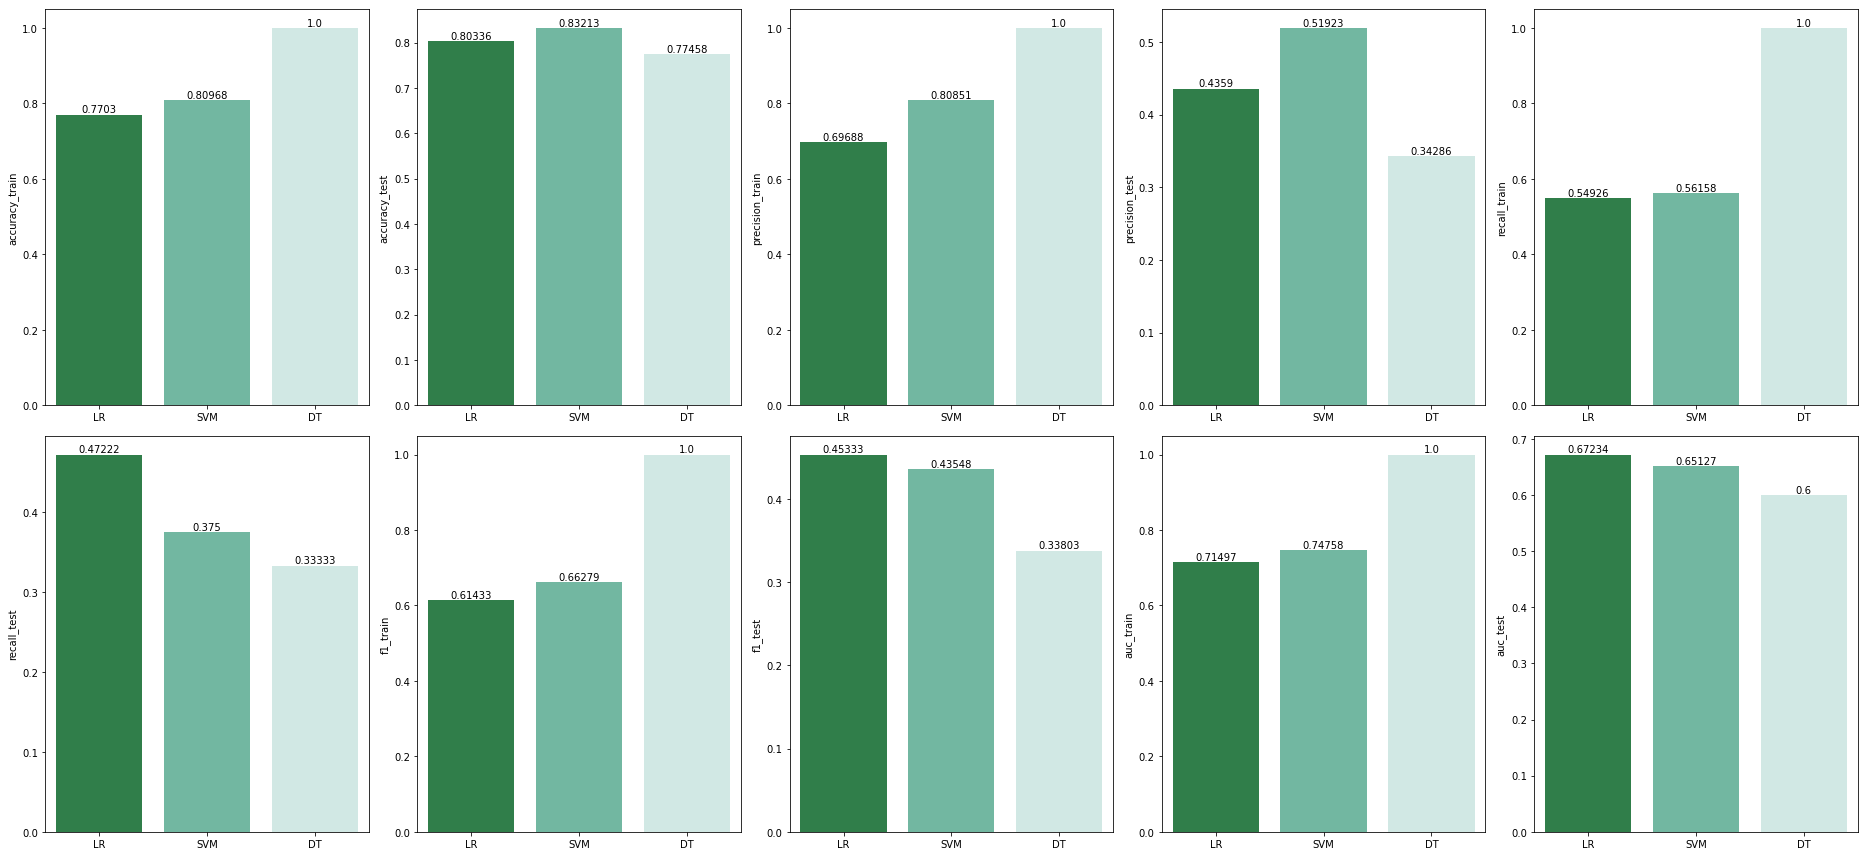

In [42]:
import math

plt.figure(figsize=(26,12))
    
for i in range(0, top3_SMOTE2.shape[1]):
    plt.subplot(2, math.ceil(top3_SMOTE2.shape[1]/2), i+1)
    ax = sns.barplot(x=top3_SMOTE2.index, y=top3_SMOTE2.columns[i], data=top3_SMOTE2, palette='BuGn_r')
    
    for p in ax.patches:
        # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() 
        ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

    plt.tight_layout()

## Lallala

In [43]:
top3_train

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
XGB,1.00000,0.82254,1.00000,0.47368,1.00000,0.25000,1.00000,0.32727,1.0000,0.59601
DT,1.00000,0.76259,1.00000,0.27869,1.00000,0.23611,1.00000,0.25564,1.0000,0.55429
GB,0.91443,0.84412,0.90217,0.64000,0.52866,0.22222,0.66667,0.32990,0.7588,0.59807


In [44]:
top3_SMOTE1

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.75646,0.73621,0.75151,0.35156,0.76630,0.62500,0.75883,0.45000,0.75646,0.69221
SVM,0.83825,0.75779,0.82277,0.36697,0.86224,0.55556,0.84204,0.44199,0.83825,0.67778
KNN,0.89176,0.70743,0.84064,0.28814,0.96679,0.47222,0.89931,0.35789,0.89176,0.61437


In [45]:
top3_SMOTE2

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.77030,0.80336,0.69688,0.43590,0.54926,0.47222,0.61433,0.45333,0.71497,0.67234
SVM,0.80968,0.83213,0.80851,0.51923,0.56158,0.37500,0.66279,0.43548,0.74758,0.65127
DT,1.00000,0.77458,1.00000,0.34286,1.00000,0.33333,1.00000,0.33803,1.00000,0.60000


# Tuning

## Data SMOTE 1

### Modelling

#### Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
model = LogisticRegression(random_state=42)
model_name = ['LR-Tuning']
score_data_tuning = []

In [48]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [50,100,200,500,1000]
multi_class = ['auto', 'ovr', 'multinomial']

hyperparameters = dict(penalty=penalty, C=C, solver=solver, max_iter=max_iter, multi_class=multi_class)

clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


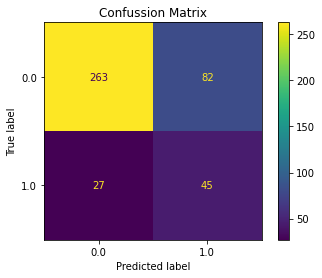

In [49]:
model = clf

model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_test)

score_data_tuning.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_test, y_test))
# print('----------------------------------------------')

In [50]:
# score_data_tuning = pd.DataFrame(score_data_tuning)
# score_data_tuning.columns = ['accuracy','precision','recall','f1','auc']
# score_data_tuning.set_axis(model_name, inplace=True)

#### KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier# import knn dari sklearn


In [52]:
model = KNeighborsClassifier()
model_name = ['KNN-Tuning']
# score_data_tuning = []

In [53]:
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

hyperparameters = dict(weights=weights, algorithm=algorithm, leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


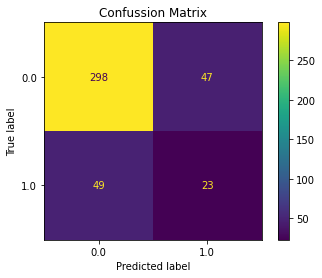

In [54]:
model = clf

model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_test)

score_data_tuning.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_test, y_test))
# print('----------------------------------------------')

In [55]:
# score_data_tuning = pd.DataFrame(score_data_tuning)
# score_data_tuning.columns = ['accuracy','precision','recall','f1','auc']
# score_data_tuning.set_axis(model_name, inplace=True)

#### Support Vector Machine (SVM)

In [56]:
from sklearn import svm


In [57]:
model = svm.SVC()
model_name = ['SVM-Tuning']
# score_data_tuning = []

In [58]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
kernel = ['linear', 'rbf', 'poly', 'sigmoid']
degree = [2, 3, 4, 5]
gamma = ['auto', 'scale']

hyperparameters = dict(C=C, kernel=kernel, degree=degree,gamma=gamma)

clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


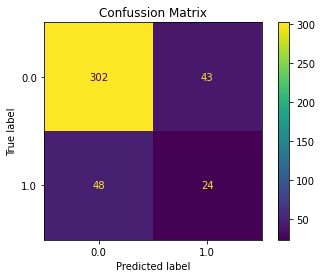

In [59]:
model = clf

model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_test)

score_data_tuning.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_test, y_test))
# print('----------------------------------------------')

In [60]:
# score_data_tuning = pd.DataFrame(score_data_tuning)
# score_data_tuning.columns = ['accuracy','precision','recall','f1','auc']
# score_data_tuning.set_axis(model_name, inplace=True)

### Save Session 

In [61]:
import dill
dill.dump_session('Stage 3 - Features by correlation.db')

### Evaluation

In [62]:
model_name = ['LR-Tuning', 'KNN-Tuning', 'SVM-Tuning']

score_data_tuning = pd.DataFrame(score_data_tuning)
score_data_tuning.columns = ['accuracy_train', 'accuracy_test','precision_train','precision_test','recall_train','recall_test','f1_train','f1_test','auc_train','auc_test']
score_data_tuning.set_axis(model_name, inplace=True)

In [63]:
score_data_tuning

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR-Tuning,0.75461,0.73861,0.75121,0.35433,0.76138,0.62500,0.75626,0.45226,0.75461,0.69366
KNN-Tuning,1.00000,0.76978,1.00000,0.32857,1.00000,0.31944,1.00000,0.32394,1.00000,0.59161
SVM-Tuning,0.95572,0.78177,0.94265,0.35821,0.97048,0.33333,0.95636,0.34532,0.95572,0.60435


In [64]:
before_after = top3_SMOTE1.append(score_data_tuning)
before_after

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR,0.75646,0.73621,0.75151,0.35156,0.76630,0.62500,0.75883,0.45000,0.75646,0.69221
SVM,0.83825,0.75779,0.82277,0.36697,0.86224,0.55556,0.84204,0.44199,0.83825,0.67778
KNN,0.89176,0.70743,0.84064,0.28814,0.96679,0.47222,0.89931,0.35789,0.89176,0.61437
LR-Tuning,0.75461,0.73861,0.75121,0.35433,0.76138,0.62500,0.75626,0.45226,0.75461,0.69366
KNN-Tuning,1.00000,0.76978,1.00000,0.32857,1.00000,0.31944,1.00000,0.32394,1.00000,0.59161
SVM-Tuning,0.95572,0.78177,0.94265,0.35821,0.97048,0.33333,0.95636,0.34532,0.95572,0.60435


In [65]:
before_after = before_after.iloc[[0,3,1,4,2,5]]

In [66]:
before_after = before_after.iloc[[0,1,2,5,4,3]]

In [172]:
before_after.iloc[[1,3,5]]

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
LR-Tuning,0.75461,0.73861,0.75121,0.35433,0.76138,0.62500,0.75626,0.45226,0.75461,0.69366
SVM-Tuning,0.95572,0.78177,0.94265,0.35821,0.97048,0.33333,0.95636,0.34532,0.95572,0.60435
KNN-Tuning,1.00000,0.76978,1.00000,0.32857,1.00000,0.31944,1.00000,0.32394,1.00000,0.59161


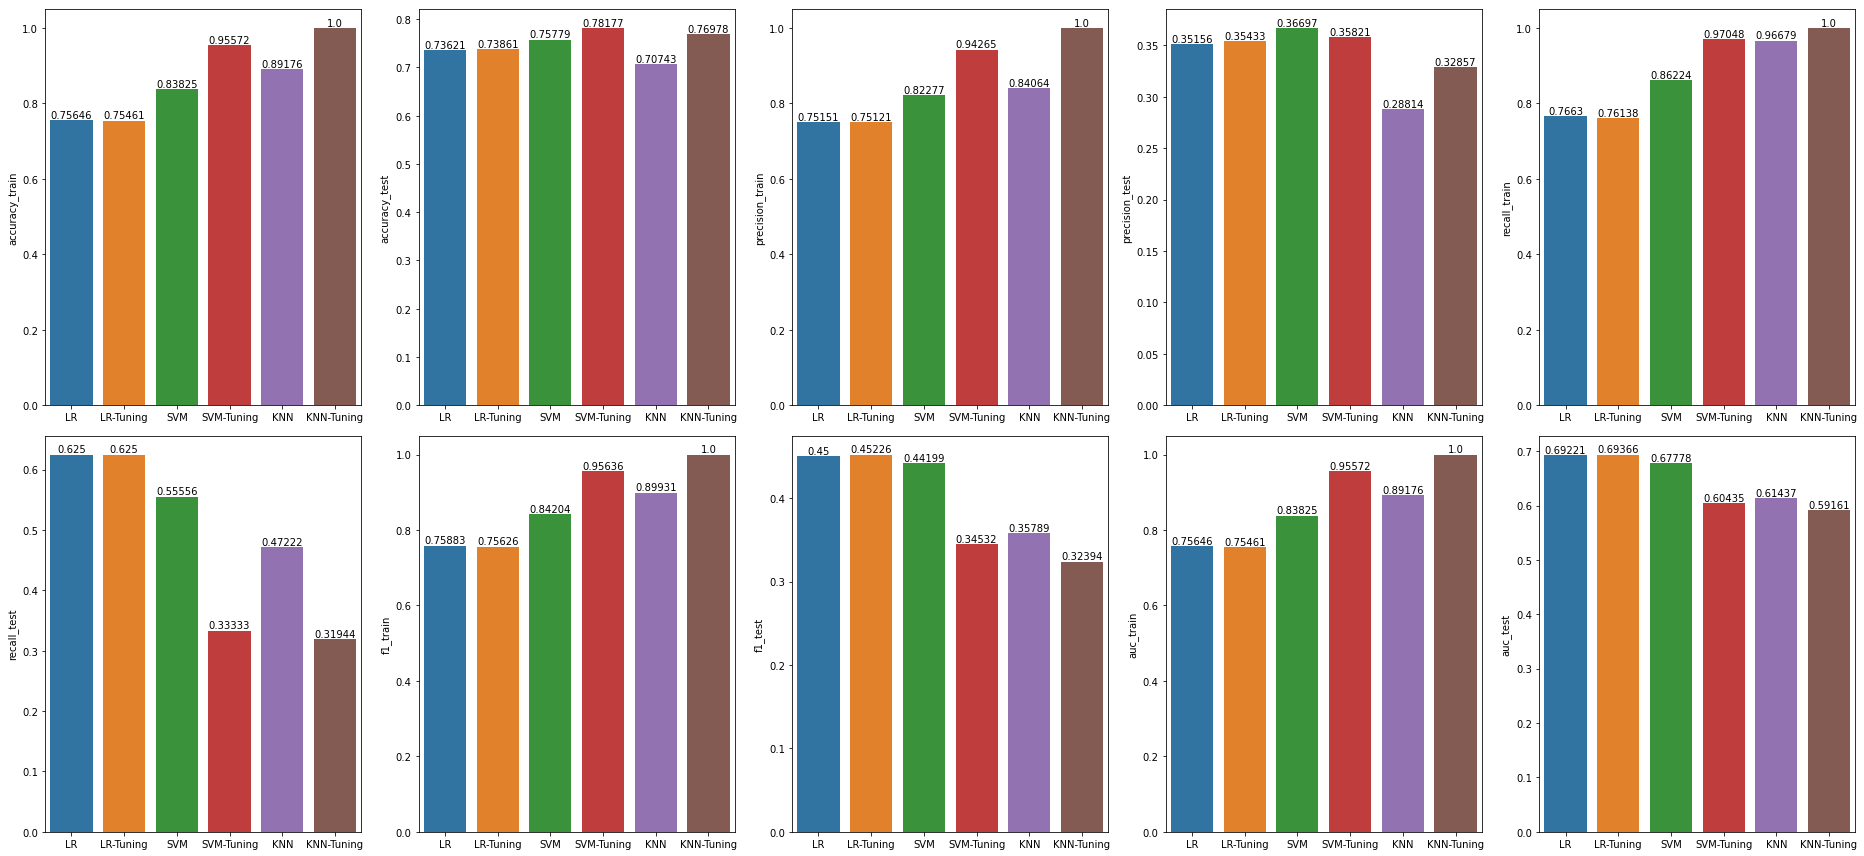

In [67]:
import math

plt.figure(figsize=(26,12))
    
for i in range(0, before_after.shape[1]):
    plt.subplot(2, math.ceil(before_after.shape[1]/2), i+1)
    ax = sns.barplot(x=before_after.index, y=before_after.columns[i], data=before_after)
    
    for p in ax.patches:
        # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() 
        ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

    plt.tight_layout()

# Simulasi

In [218]:
# load session STAGE 3
import dill
dill.load_session('Stage 3 - Features by correlation.db')

In [219]:
import joblib

scaler_standar = joblib.load("scaler_standar.pkl")
scaler_robust = joblib.load("scaler_robust.pkl")

# Before Simulasi

In [220]:
# simulasi menggunakan 30% data
df_before_simulasi = train.append(test)
n = round(df_before_simulasi.shape[0] * 30/100)
df_before_simulasi = df_before_simulasi.sample(n, random_state=42).reset_index(drop=True)

In [221]:
df_before_simulasi.shape

(416, 31)

In [222]:
features_by_correaltion

['OverTime_label',
 'TotalWorkingYears',
 'JobLevel',
 'YearsInCurrentRole',
 'YearsAtCompany',
 'YearsWithCurrManager',
 'MonthlyIncome',
 'MaritalStatus_label',
 'Age',
 'WorkLifeBalance']

In [223]:
X_simulasi = df_before_simulasi[features_by_correaltion]
y_simulasi = df_before_simulasi.iloc[:, -1:]

In [224]:
from sklearn.linear_model import LogisticRegression

In [225]:
model = LogisticRegression(random_state=42)
model_name = ['Simulasi (Before)']
score_data_simulasi = []

In [226]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [50,100,200,500,1000]
multi_class = ['auto', 'ovr', 'multinomial']

hyperparameters = dict(penalty=penalty, C=C, solver=solver, max_iter=max_iter, multi_class=multi_class)

clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


C:\Users\Attariq\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.5        ...        nan 0.75031996 0.75031996]
  warnings.warn(
C:\Users\Attariq\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


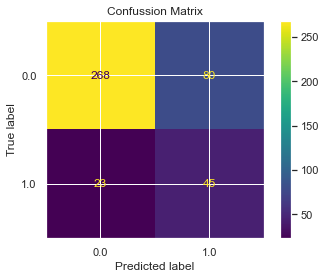

In [227]:
model = clf

model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_simulasi)

score_data_simulasi.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_simulasi, y_simulasi))
# print('----------------------------------------------')

C:\Users\Attariq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Before Simulasi')

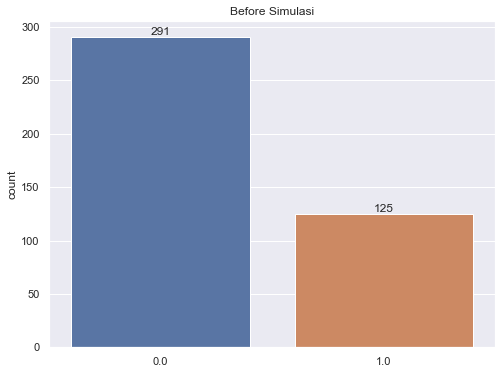

In [228]:
plt.figure(figsize=(8,6))

ax = sns.countplot(model.predict(X_simulasi))

for p in ax.patches:
    # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() 
    ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

plt.title('Before Simulasi')

In [229]:
# score_data_simulasi = pd.DataFrame(score_data_simulasi)
# score_data_simulasi.columns = ['accuracy_train', 'accuracy_test','precision_train','precision_test','recall_train','recall_test','f1_train','f1_test','auc_train','auc_test']
# score_data_simulasi.set_axis(model_name, inplace=True)

In [230]:
# score_data_simulasi

# After Simulasi

## Simulasi Overtime - 1

### Data

In [231]:
# simulasi menggunakan 30% data
df_simulasi_1 = df_before_simulasi.copy()

In [232]:
df_simulasi_1['OverTime_label'].value_counts()

0.0    305
1.0    111
Name: OverTime_label, dtype: int64

In [233]:
# membagi data yang ingin di rubah sebesar 20% dari data sample (yang overtime = 1 saja)
df_simulasi_over1, df_simulasi_over2 = train_test_split(df_simulasi_1[df_simulasi_1['OverTime_label'] == 1], test_size=0.2, random_state=42)

# merubah semua data yang overtime menjadi tidak overtime
df_simulasi_over2['OverTime_label'] = 0.0 

df_simulasi_over = df_simulasi_over1.append(df_simulasi_over2)
df_simulasi_1 = df_simulasi_over.append(df_simulasi_1[df_simulasi_1['OverTime_label'] == 0])

In [234]:
df_simulasi_1['OverTime_label'].value_counts()

0.0    328
1.0     88
Name: OverTime_label, dtype: int64

In [235]:
X_simulasi = df_simulasi_1[features_by_correaltion]
y_simulasi = df_simulasi_1.iloc[:, -1:]

### Modelling Simulasi

In [236]:
# from sklearn.linear_model import LogisticRegression

In [237]:
# model = LogisticRegression(random_state=42)
model_name.append('Simulasi-Overtime')
# score_data_simulasi = []

In [238]:
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# max_iter = [50,100,200,500,1000]
# multi_class = ['auto', 'ovr', 'multinomial']

# hyperparameters = dict(penalty=penalty, C=C, solver=solver, max_iter=max_iter, multi_class=multi_class)

# clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


C:\Users\Attariq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Simulasi Overtime')

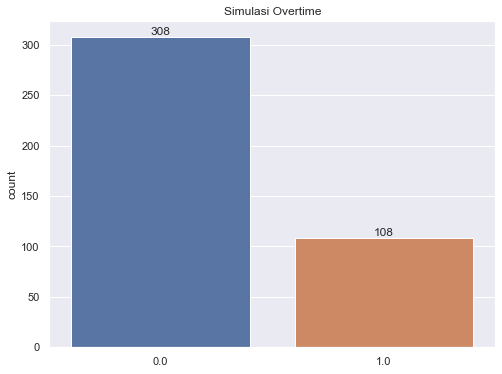

In [239]:
plt.figure(figsize=(8,6))

ax = sns.countplot(model.predict(X_simulasi))

for p in ax.patches:
    # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() 
    ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

plt.title('Simulasi Overtime')

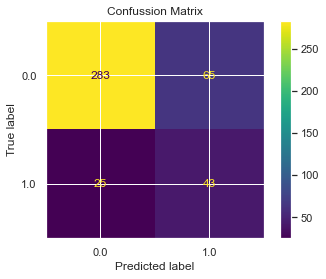

In [240]:
# model = clf

# model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_simulasi)

score_data_simulasi.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_simulasi, y_simulasi))
# print('----------------------------------------------')

In [241]:
# score_data_simulasi = pd.DataFrame(score_data_simulasi)
# score_data_simulasi.columns = ['accuracy_train', 'accuracy_test','precision_train','precision_test','recall_train','recall_test','f1_train','f1_test','auc_train','auc_test']
# score_data_simulasi.set_axis(model_name, inplace=True)

In [242]:
# score_data_simulasi

## Simulasi Job Level - 2

### Data

In [243]:
# simulasi menggunakan 30% data
df_simulasi_2 = df_before_simulasi.copy()

In [244]:
df_simulasi_2.value_counts(subset='JobLevel')

JobLevel
-1.0    162
 0.0    153
 1.0     65
 2.0     21
 3.0     15
dtype: int64

In [245]:
# membagi data yang ingin di rubah sebesar 30% -1, 15% 0, 5% 1, 3% 2
df_simulasi_jl1_1, df_simulasi_jl1_2 = train_test_split(df_simulasi_2[df_simulasi_2['JobLevel'] == -1.0], test_size=0.3, random_state=42)
df_simulasi_jl2_1, df_simulasi_jl2_2 = train_test_split(df_simulasi_2[df_simulasi_2['JobLevel'] == 0.0], test_size=0.15, random_state=42)
df_simulasi_jl3_1, df_simulasi_jl3_2 = train_test_split(df_simulasi_2[df_simulasi_2['JobLevel'] == 1.0], test_size=0.05, random_state=42)
df_simulasi_jl4_1, df_simulasi_jl4_2 = train_test_split(df_simulasi_2[df_simulasi_2['JobLevel'] == 2.0], test_size=0.03, random_state=42)

# merubah data naik tingkat 1 (naik jabatan)
df_simulasi_jl1_2['JobLevel'] = 0.0 
df_simulasi_jl2_2['JobLevel'] = 1.0 
df_simulasi_jl3_2['JobLevel'] = 2.0 
df_simulasi_jl4_2['JobLevel'] = 3.0 

df_simulasi_jl1 = df_simulasi_jl1_1.append(df_simulasi_jl1_2)
df_simulasi_jl2 = df_simulasi_jl2_1.append(df_simulasi_jl2_2)
df_simulasi_jl3 = df_simulasi_jl3_1.append(df_simulasi_jl3_2)
df_simulasi_jl4 = df_simulasi_jl4_1.append(df_simulasi_jl4_2)

df_simulasi_2 = df_simulasi_2[df_simulasi_2['JobLevel'].isin([3])]
df_simulasi_2 = pd.concat([df_simulasi_2, df_simulasi_jl1, df_simulasi_jl2, df_simulasi_jl3, df_simulasi_jl4], axis=0)

In [246]:
df_simulasi_2.value_counts(subset='JobLevel')

JobLevel
 0.0    179
-1.0    113
 1.0     84
 2.0     24
 3.0     16
dtype: int64

In [247]:
X_simulasi = df_simulasi_2[features_by_correaltion]
y_simulasi = df_simulasi_2.iloc[:, -1:]

### Modelling Simulasi

In [248]:
# from sklearn.linear_model import LogisticRegression

In [249]:
# model = LogisticRegression(random_state=42)
model_name.append('Simulasi-JobLevel')
# # score_data_simulasi = []

In [250]:
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# max_iter = [50,100,200,500,1000]
# multi_class = ['auto', 'ovr', 'multinomial']

# hyperparameters = dict(penalty=penalty, C=C, solver=solver, max_iter=max_iter, multi_class=multi_class)

# clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


C:\Users\Attariq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Simulasi Job Level')

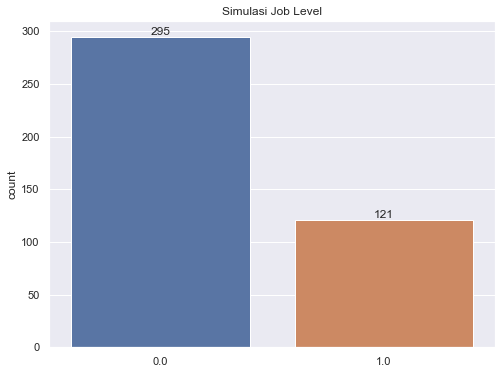

In [251]:
plt.figure(figsize=(8,6))

ax = sns.countplot(model.predict(X_simulasi))

for p in ax.patches:
    # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() 
    ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

plt.title('Simulasi Job Level')

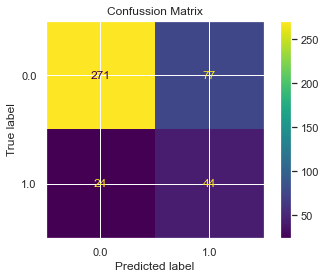

In [252]:
# model = clf

# model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_simulasi)

score_data_simulasi.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_simulasi, y_simulasi))
# print('----------------------------------------------')

## Simulasi Monthly Income - 3

### Data

In [253]:
# simulasi menggunakan 30% data
df_simulasi_3 = df_before_simulasi.copy()

In [254]:
# membagi data yang ingin di rubah sebesar 20% dari data sample
n = round(df_simulasi_3.shape[0] * 20/100)

df_simulasi_3_1 = df_simulasi_3.sort_values(by='MonthlyIncome').iloc[n:]
df_simulasi_3_2 = df_simulasi_3.sort_values(by='MonthlyIncome').iloc[:n]

In [255]:
df_simulasi_3_2['MonthlyIncome'].min()

-0.8234505862646566

In [256]:
# simulasi naik gaji sebesar 20% 
df_simulasi_3_2['MonthlyIncome'] = df_simulasi_3_2['MonthlyIncome'] + abs(df_simulasi_3_2['MonthlyIncome'] * 20/100)

df_simulasi_3 = pd.concat([df_simulasi_3_1, df_simulasi_3_2], axis=0)

In [257]:
df_simulasi_3_2['MonthlyIncome'].min()

-0.6587604690117252

In [258]:
X_simulasi = df_simulasi_3[features_by_correaltion]
y_simulasi = df_simulasi_3.iloc[:, -1:]

### Modelling Simulasi

In [259]:
# from sklearn.linear_model import LogisticRegression

In [260]:
# model = LogisticRegression(random_state=42)
model_name.append('Simulasi-Montlhy Income')
# # score_data_simulasi = []

In [261]:
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# max_iter = [50,100,200,500,1000]
# multi_class = ['auto', 'ovr', 'multinomial']

# hyperparameters = dict(penalty=penalty, C=C, solver=solver, max_iter=max_iter, multi_class=multi_class)

# clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


C:\Users\Attariq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Simulasi Monthly Income')

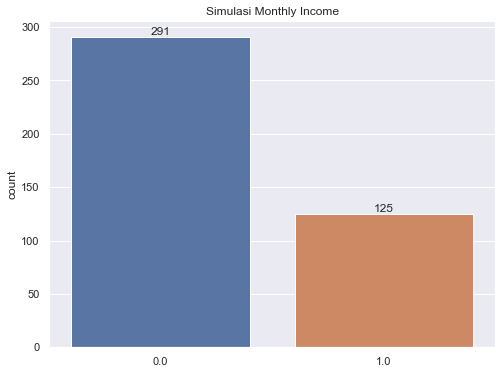

In [262]:
plt.figure(figsize=(8,6))

ax = sns.countplot(model.predict(X_simulasi))

for p in ax.patches:
    # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() 
    ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

plt.title('Simulasi Monthly Income')

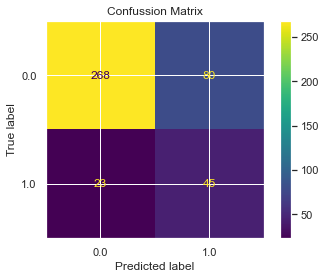

In [263]:
# model = clf

# model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_simulasi)

score_data_simulasi.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_simulasi, y_simulasi))
# print('----------------------------------------------')

## Simulasi Marital Status - 4

### Data

In [264]:
# simulasi menggunakan 30% data
df_simulasi_4 = df_before_simulasi.copy()

In [265]:
df_simulasi_4['MaritalStatus_label'].value_counts()

 0.0    200
 1.0    122
-1.0     94
Name: MaritalStatus_label, dtype: int64

In [266]:
# membagi data yang ingin di rubah sebesar 20% dari data sample
df_simulasi_ms1, df_simulasi_ms2 = train_test_split(df_simulasi_4[df_simulasi_4['MaritalStatus_label'] == 1], test_size=0.2, random_state=42)

# merubah data (menikah)
df_simulasi_ms2['MaritalStatus_label'] = 0.0 

df_simulasi_ms = df_simulasi_ms1.append(df_simulasi_ms2)

df_simulasi_4 = df_simulasi_4[df_simulasi_4['MaritalStatus_label'].isin([0,-1])]
df_simulasi_4 = pd.concat([df_simulasi_4, df_simulasi_ms], axis=0)

In [267]:
df_simulasi_4['MaritalStatus_label'].value_counts()

 0.0    225
 1.0     97
-1.0     94
Name: MaritalStatus_label, dtype: int64

In [268]:
X_simulasi = df_simulasi_4[features_by_correaltion]
y_simulasi = df_simulasi_4.iloc[:, -1:]

### Modelling Simulasi

In [269]:
# from sklearn.linear_model import LogisticRegression

In [270]:
# model = LogisticRegression(random_state=42)
model_name.append('Simulasi-Marital Status')
# # score_data_simulasi = []

In [271]:
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# max_iter = [50,100,200,500,1000]
# multi_class = ['auto', 'ovr', 'multinomial']

# hyperparameters = dict(penalty=penalty, C=C, solver=solver, max_iter=max_iter, multi_class=multi_class)

# clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


C:\Users\Attariq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Simulasi Marital Status')

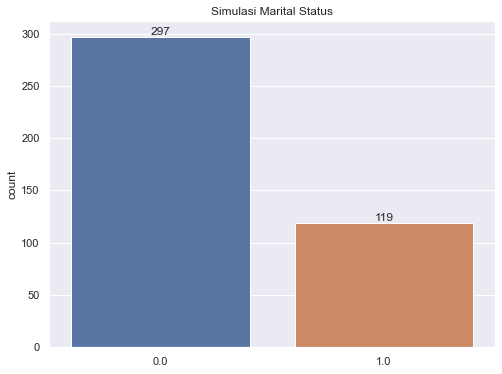

In [272]:
plt.figure(figsize=(8,6))

ax = sns.countplot(model.predict(X_simulasi))

for p in ax.patches:
    # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() 
    ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

plt.title('Simulasi Marital Status')

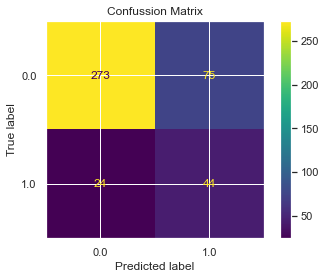

In [273]:
# model = clf

# model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_simulasi)

score_data_simulasi.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_simulasi, y_simulasi))
# print('----------------------------------------------')

## Simulasi Work Life Balance - 5

### Data

In [274]:
# simulasi menggunakan 30% data
df_simulasi_5 = df_before_simulasi.copy()

In [275]:
df_simulasi_5.value_counts(subset='WorkLifeBalance')

WorkLifeBalance
 0.0    253
-1.0    101
 1.0     40
-2.0     22
dtype: int64

In [276]:
# membagi data yang ingin di rubah sebesar 20% dari data sample
df_simulasi_wlb1_1, df_simulasi_wlb1_2 = train_test_split(df_simulasi_5[df_simulasi_5['WorkLifeBalance'] == -2], test_size=0.2, random_state=42)
df_simulasi_wlb2_1, df_simulasi_wlb2_2 = train_test_split(df_simulasi_5[df_simulasi_5['WorkLifeBalance'] == -1], test_size=0.2, random_state=42)

# merubah data (low menjadi good)
df_simulasi_wlb1_2['WorkLifeBalance'] = -1.0 
df_simulasi_wlb2_2['WorkLifeBalance'] = 0.0 

df_simulasi_wlb1 = df_simulasi_wlb1_1.append(df_simulasi_wlb1_2)
df_simulasi_wlb2 = df_simulasi_wlb2_1.append(df_simulasi_wlb2_2)

df_simulasi_5 = df_simulasi_5[df_simulasi_5['WorkLifeBalance'].isin([0,1])]
df_simulasi_5 = pd.concat([df_simulasi_5, df_simulasi_wlb1, df_simulasi_wlb2], axis=0)

In [277]:
df_simulasi_5.value_counts(subset='WorkLifeBalance')

WorkLifeBalance
 0.0    274
-1.0     85
 1.0     40
-2.0     17
dtype: int64

In [278]:
X_simulasi = df_simulasi_5[features_by_correaltion]
y_simulasi = df_simulasi_5.iloc[:, -1:]

### Modelling Simulasi

In [279]:
# from sklearn.linear_model import LogisticRegression

In [280]:
# model = LogisticRegression(random_state=42)
model_name.append('Simulasi-Work Life Balance')
# # score_data_simulasi = []

In [281]:
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# max_iter = [50,100,200,500,1000]
# multi_class = ['auto', 'ovr', 'multinomial']

# hyperparameters = dict(penalty=penalty, C=C, solver=solver, max_iter=max_iter, multi_class=multi_class)

# clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


C:\Users\Attariq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Simulasi Work Life Balance')

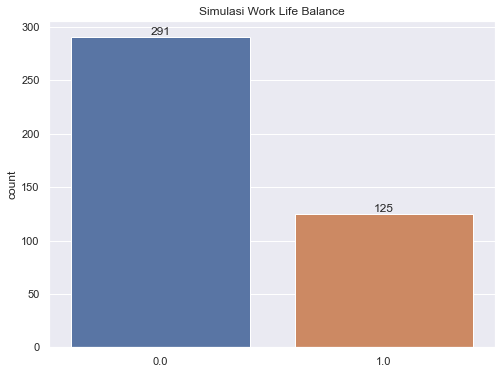

In [282]:
plt.figure(figsize=(8,6))

ax = sns.countplot(model.predict(X_simulasi))

for p in ax.patches:
    # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() 
    ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

plt.title('Simulasi Work Life Balance')

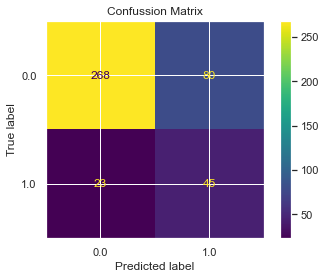

In [283]:
# model = clf

# model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_simulasi)

score_data_simulasi.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_simulasi, y_simulasi))
# print('----------------------------------------------')

## Simulasi Final Gabungan

### Data

In [284]:
# simulasi menggunakan 30% data
df_simulasi_final = df_before_simulasi.copy()

In [285]:
df_before_simulasi.shape

(416, 31)

#### Overtime

In [286]:
df_simulasi_final['OverTime_label'].value_counts()

0.0    305
1.0    111
Name: OverTime_label, dtype: int64

In [287]:
# membagi data yang ingin di rubah sebesar 20% dari data sample (yang overtime = 1 saja)
df_simulasi_over1, df_simulasi_over2 = train_test_split(df_simulasi_final[df_simulasi_final['OverTime_label'] == 1], test_size=0.2, random_state=42)

# merubah semua data yang overtime menjadi tidak overtime
df_simulasi_over2['OverTime_label'] = 0.0 

df_simulasi_over = df_simulasi_over1.append(df_simulasi_over2)
df_simulasi_final = df_simulasi_over.append(df_simulasi_final[df_simulasi_final['OverTime_label'] == 0])

In [288]:
print(df_simulasi_over2.shape)


(23, 31)


#### Job Level

In [289]:
df_simulasi_final.value_counts(subset='JobLevel')

JobLevel
-1.0    162
 0.0    153
 1.0     65
 2.0     21
 3.0     15
dtype: int64

In [290]:
# membagi data yang ingin di rubah sebesar 20% dari data sample (yang overtime = 1 saja)
df_simulasi_jl1_1, df_simulasi_jl1_2 = train_test_split(df_simulasi_final[df_simulasi_final['JobLevel'] == -1.0], test_size=0.1, random_state=42)
df_simulasi_jl2_1, df_simulasi_jl2_2 = train_test_split(df_simulasi_final[df_simulasi_final['JobLevel'] == 0.0], test_size=0.1, random_state=42)

# merubah semua data yang overtime menjadi tidak overtime
df_simulasi_jl1_2['JobLevel'] = 0.0 
df_simulasi_jl2_2['JobLevel'] = 1.0 

df_simulasi_jl1 = df_simulasi_jl1_1.append(df_simulasi_jl1_2)
df_simulasi_jl2 = df_simulasi_jl2_1.append(df_simulasi_jl2_2)

df_simulasi_final = df_simulasi_final[df_simulasi_final['JobLevel'].isin([1,2,3])]
df_simulasi_final = pd.concat([df_simulasi_final, df_simulasi_jl1, df_simulasi_jl2], axis=0)

In [291]:
print(df_simulasi_jl1_2.shape)
print(df_simulasi_jl2_2.shape)

(17, 31)
(16, 31)


#### Monthly Income

In [292]:
# membagi data yang ingin di rubah sebesar 20% dari data sample
n = round(df_simulasi_final.shape[0] * 20/100)

df_simulasi_final_1 = df_simulasi_final.sort_values(by='MonthlyIncome').iloc[n:]
df_simulasi_final_2 = df_simulasi_final.sort_values(by='MonthlyIncome').iloc[:n]

In [293]:
df_simulasi_final['MonthlyIncome'].min()

-0.8234505862646566

In [294]:
# simulasi naik gaji sebesar 20% 
df_simulasi_final_2['MonthlyIncome'] = df_simulasi_final_2['MonthlyIncome'] + abs(df_simulasi_final_2['MonthlyIncome'] * 20/100)

df_simulasi_final = pd.concat([df_simulasi_final_1, df_simulasi_final_2], axis=0)

In [295]:
print(df_simulasi_final_2.shape)


(83, 31)


In [296]:
df_simulasi_final['MonthlyIncome'].min()

-0.6587604690117252

#### Marital Status

In [297]:
df_simulasi_final['MaritalStatus_label'].value_counts()

 0.0    200
 1.0    122
-1.0     94
Name: MaritalStatus_label, dtype: int64

In [298]:
# membagi data yang ingin di rubah sebesar 20% dari data sample
df_simulasi_ms1, df_simulasi_ms2 = train_test_split(df_simulasi_final[df_simulasi_final['MaritalStatus_label'] == 1], test_size=0.2, random_state=42)

# merubah data (menikah)
df_simulasi_ms2['MaritalStatus_label'] = 0.0 

df_simulasi_ms = df_simulasi_ms1.append(df_simulasi_ms2)

df_simulasi_final = df_simulasi_final[df_simulasi_final['MaritalStatus_label'].isin([0,-1])]
df_simulasi_final = pd.concat([df_simulasi_final, df_simulasi_ms], axis=0)

In [299]:
print(df_simulasi_ms2.shape)


(25, 31)


In [300]:
df_simulasi_final['MaritalStatus_label'].value_counts()

 0.0    225
 1.0     97
-1.0     94
Name: MaritalStatus_label, dtype: int64

#### Work Life Balance

In [301]:
df_simulasi_final['WorkLifeBalance'].value_counts()

 0.0    253
-1.0    101
 1.0     40
-2.0     22
Name: WorkLifeBalance, dtype: int64

In [302]:
# membagi data yang ingin di rubah sebesar 20% dari data sample
df_simulasi_wlb1_1, df_simulasi_wlb1_2 = train_test_split(df_simulasi_final[df_simulasi_final['WorkLifeBalance'] == -2], test_size=0.2, random_state=42)
df_simulasi_wlb2_1, df_simulasi_wlb2_2 = train_test_split(df_simulasi_final[df_simulasi_final['WorkLifeBalance'] == -1], test_size=0.2, random_state=42)

# merubah data (low menjadi good)
df_simulasi_wlb1_2['WorkLifeBalance'] = -1.0 
df_simulasi_wlb2_2['WorkLifeBalance'] = 0.0 

df_simulasi_wlb1 = df_simulasi_wlb1_1.append(df_simulasi_wlb1_2)
df_simulasi_wlb2 = df_simulasi_wlb2_1.append(df_simulasi_wlb2_2)

df_simulasi_final = df_simulasi_final[df_simulasi_final['WorkLifeBalance'].isin([0,1])]
df_simulasi_final = pd.concat([df_simulasi_final, df_simulasi_wlb1, df_simulasi_wlb2], axis=0)

In [303]:
print(df_simulasi_wlb1_2.shape)
print(df_simulasi_wlb2_2.shape)

(5, 31)
(21, 31)


In [304]:
df_simulasi_final['WorkLifeBalance'].value_counts()

 0.0    274
-1.0     85
 1.0     40
-2.0     17
Name: WorkLifeBalance, dtype: int64

### Modelling Simulasi

In [305]:
X_simulasi = df_simulasi_final[features_by_correaltion]
y_simulasi = df_simulasi_final.iloc[:, -1:]

In [306]:
# from sklearn.linear_model import LogisticRegression

In [307]:
# model = LogisticRegression(random_state=42)
model_name.append('Simulasi-Gabungan')
# # score_data_simulasi = []

In [308]:
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# max_iter = [50,100,200,500,1000]
# multi_class = ['auto', 'ovr', 'multinomial']

# hyperparameters = dict(penalty=penalty, C=C, solver=solver, max_iter=max_iter, multi_class=multi_class)

# clf = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)


C:\Users\Attariq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Simulasi Gabungan')

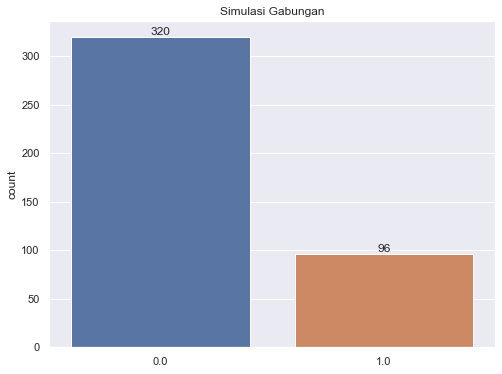

In [309]:
plt.figure(figsize=(8,6))

ax = sns.countplot(model.predict(X_simulasi))

for p in ax.patches:
    # percentage = f'{100 * p.get_height() / total1:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() 
    ax.annotate(f'\n{p.get_height()}', (x, y), ha='center', va='bottom')

plt.title('Simulasi Gabungan')

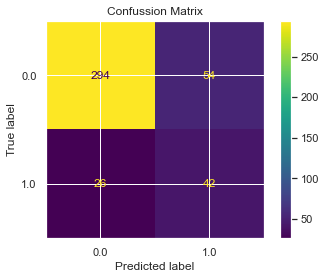

In [310]:
# model = clf

# model.fit(X_smote_1, y_smote_1)
y_pred_train = model.predict(X_smote_1)
y_pred_test = model.predict(X_simulasi)

score_data_simulasi.append(eval_classification(model, y_pred_train, y_pred_test, X_smote_1, y_smote_1, X_simulasi, y_simulasi))
# print('----------------------------------------------')

In [311]:
score_data_simulasi = pd.DataFrame(score_data_simulasi)
score_data_simulasi.columns = ['accuracy_train', 'accuracy_test','precision_train','precision_test','recall_train','recall_test','f1_train','f1_test','auc_train','auc_test']
score_data_simulasi.set_axis(model_name, inplace=True)

In [312]:
score_data_simulasi

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
Simulasi (Before),0.75461,0.75240,0.75121,0.36000,0.76138,0.66176,0.75626,0.46632,0.75461,0.71594
Simulasi-Overtime,0.75461,0.78365,0.75121,0.39815,0.76138,0.63235,0.75626,0.48864,0.75461,0.72279
Simulasi-JobLevel,0.75461,0.75721,0.75121,0.36364,0.76138,0.64706,0.75626,0.46561,0.75461,0.71290
Simulasi-Montlhy Income,0.75461,0.75240,0.75121,0.36000,0.76138,0.66176,0.75626,0.46632,0.75461,0.71594
Simulasi-Marital Status,0.75461,0.76202,0.75121,0.36975,0.76138,0.64706,0.75626,0.47059,0.75461,0.71577
Simulasi-Work Life Balance,0.75461,0.75240,0.75121,0.36000,0.76138,0.66176,0.75626,0.46632,0.75461,0.71594
Simulasi-Gabungan,0.75461,0.80769,0.75121,0.43750,0.76138,0.61765,0.75626,0.51220,0.75461,0.73124


## Eval

In [313]:
score_data_simulasi = pd.DataFrame(score_data_simulasi)
score_data_simulasi.columns = ['accuracy_train', 'accuracy_test','precision_train','precision_test','recall_train','recall_test','f1_train','f1_test','auc_train','auc_test']
score_data_simulasi.set_axis(model_name, inplace=True)

In [314]:
score_data_simulasi

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
Simulasi (Before),0.75461,0.75240,0.75121,0.36000,0.76138,0.66176,0.75626,0.46632,0.75461,0.71594
Simulasi-Overtime,0.75461,0.78365,0.75121,0.39815,0.76138,0.63235,0.75626,0.48864,0.75461,0.72279
Simulasi-JobLevel,0.75461,0.75721,0.75121,0.36364,0.76138,0.64706,0.75626,0.46561,0.75461,0.71290
Simulasi-Montlhy Income,0.75461,0.75240,0.75121,0.36000,0.76138,0.66176,0.75626,0.46632,0.75461,0.71594
Simulasi-Marital Status,0.75461,0.76202,0.75121,0.36975,0.76138,0.64706,0.75626,0.47059,0.75461,0.71577
Simulasi-Work Life Balance,0.75461,0.75240,0.75121,0.36000,0.76138,0.66176,0.75626,0.46632,0.75461,0.71594
Simulasi-Gabungan,0.75461,0.80769,0.75121,0.43750,0.76138,0.61765,0.75626,0.51220,0.75461,0.73124


In [315]:
train['Attrition_label'].value_counts()

0.0    813
1.0    157
Name: Attrition_label, dtype: int64

In [316]:
df_yes = df_zscore[df_zscore['Attrition'] == 'Yes']
df_yes.sort_values(by='YearsAtCompany', inplace=True, ascending=False)

<ipython-input-316-0b61ecbedc63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yes.sort_values(by='YearsAtCompany', inplace=True, ascending=False)


In [317]:
map_years_company = {}
for i in df_yes['YearsAtCompany'].unique():
    map_years_company[i] = 2021 - i
map_years_company

{24: 1997,
 20: 2001,
 19: 2002,
 18: 2003,
 16: 2005,
 15: 2006,
 14: 2007,
 13: 2008,
 11: 2010,
 10: 2011,
 9: 2012,
 8: 2013,
 7: 2014,
 6: 2015,
 5: 2016,
 4: 2017,
 3: 2018,
 2: 2019,
 1: 2020,
 0: 2021}

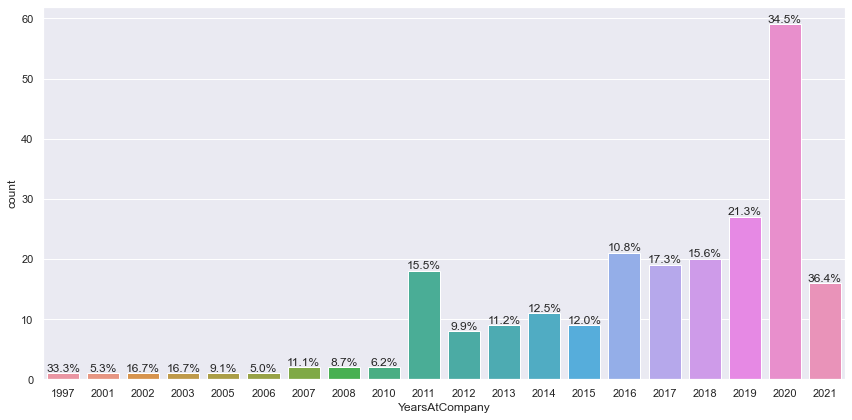

In [318]:
sns.set(style='darkgrid')
plt.figure(figsize=(12,6))

ax = sns.countplot(x=df_yes['YearsAtCompany'].map(map_years_company),data=df_yes)
# ax = sns.countplot(x='YearsAtCompany',data=df_yes)

for i,p in enumerate(ax.patches):
    total = len(df_zscore[df_zscore['YearsAtCompany'] == df_yes['YearsAtCompany'].unique()[i]])
    percentage = f'{100*p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [319]:
df_zscore.value_counts(subset='YearsAtCompany').sort_index()

YearsAtCompany
0      44
1     171
2     127
3     128
4     110
5     195
6      75
7      88
8      80
9      81
10    116
11     32
12     14
13     23
14     18
15     20
16     11
17      3
18      6
19      6
20     19
21      7
22      7
24      3
25      3
dtype: int64

In [320]:
df_yes.value_counts(subset='YearsAtCompany').sort_index()

YearsAtCompany
0     16
1     59
2     27
3     20
4     19
5     21
6      9
7     11
8      9
9      8
10    18
11     2
13     2
14     2
15     1
16     1
18     1
19     1
20     1
24     1
dtype: int64